# Overview

In this notebook, we conduct outlier detecion of the  dataset obtained from the previous data cleaning. 

In [1]:
import pandas as pd
import numpy as np
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
import re
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_hdf('../data/cleaned_dataset_v1.h5',  key='data')
df.fillna(0, inplace=True)
df.shape

(46192, 9142)

# Datacleaning and preprocessing


The data cleaning performed in the current session involves eliminating columns where all values are zero, as well as removing the initial number of series calculated from the merged file. Subsequently, recalculations were done using columns from the processed table in data_merged_table.ipynb. Additionally, total reps and total time values were calculated for all exercises, as well as for individual exercises.

## Nomenclature

- **variable**: Number of series. (e.g. 1 leg bridge (left) = 10)
- **variable**\_**reps**\_**n**: Number of reps per serie . (e.g. 1 leg bridge (left)_reps_1 = 5 -> 5 reps in the serie 1)
- **variable**\_**time**\_**n**: Time in seconds per serie (e.g. 1 leg bridge (left)_time_2 = 30s -> 30s in the serie 2)
- **sum_of_reps**: Sum of all the rep values executed during the session.
- **sum_of_time**: Sum of the total time values for all the exercises during the session.
- **sum_of_reps_per_exercise**: Sum of the rep values executed during the session per exercise.
- **sum_of_time_per_exercise**: Sum of the time values during the session per exercise.
- **total_count_of_series_reps**: The count of the series for reps.
- **total_count_of_series_time**: The count of the sereis for time.


In [3]:
# Removing all columns with zero values
columns_with_zero_values = df.columns[(df == 0).all()]
df = df.drop(columns=columns_with_zero_values)
df.head(5)

,session_executions_updated_at,user_programs_user_id,1 leg bridge (left),1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right),1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left),1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right),1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right),1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (righ

In [6]:
# Removing the Initial columns that containt the total number of series 
columns_without_reps_and_time = df.columns[~((df.columns.str.contains("_reps_")) |
                                             (df.columns.str.contains("_time_")) |      
                                             (df.columns.str.contains("session_executions_updated_at")) |
                                             (df.columns.str.contains("user_programs_user_id")) |
                                             (df.columns.str.contains("date")) |                                             
                                             (df.columns.str.contains("session_executions_summary_total_kcal")) |
                                             (df.columns.str.contains("session_executions_summary_effort")) |
                                             (df.columns.str.contains("session_executions_summary_points")) |
                                             (df.columns.str.contains("session_executions_summary_value_of_session")) )]

df = df.drop(columns=columns_without_reps_and_time)
df.shape

(46192, 6909)

In [7]:
def add_count_and_sum_columns(df):
    """
    Add the followings columns to a DataFrame.
    sum_of_reps: Sum of all the rep values executed during the session.
    sum_of_time: Sum of the total time values for all the exercises during the session.
    sum_of_reps_per_exercise: Sum of the rep values executed during the session per exercise.
    sum_of_time_per_exercise: Sum of the time values during the session per exercise.
    total_count_of_series_reps: The count of the series for reps.
    total_count_of_series_time: The count of the sereis for time.

    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with added columns.
    """
    count_reps_all = {}
    
    for index, row in df.iterrows():
        
        # Get the name of the columns which the values are different from zero
        series_name = row[row.astype(bool)].keys()
        
        # Initialize empty dicts to store the variables to add
        count_reps = {}
        sum_of_reps = {'sum_of_reps':0}
        sum_of_reps_per_exercise = {}
        count_times = {}
        sum_of_time = {'sum_of_time':0}
        sum_of_time_per_exercise = {}

        # Loop through each item in the series
        for item in series_name:

            if "_reps_" in item:
                
                # Split the item by "_reps_" to extract the group name
                group_name_reps = item.split("_reps_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_reps + "_reps") not in count_reps:
                    count_reps[group_name_reps + "_reps"] = 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = 0
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_reps[group_name_reps + "_reps"] += 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                sum_of_reps['sum_of_reps'] = sum_of_reps['sum_of_reps'] + row[item]

            elif ("_time_") in item:
                
                # Split the item by "_time_" to extract the group name
                group_name_time = item.split("_time_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_time + "_time") not in count_times:
                    count_times[group_name_time + "_time"] = 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = 0
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_times[group_name_time + "_time"] += 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                sum_of_time['sum_of_time'] = sum_of_time['sum_of_time'] + row[item]
            else:
                pass

        count_reps['total_count_of_series_reps'] = sum(count_reps.values())
        count_times['total_count_of_series_time'] = sum(count_times.values())

        count_reps_all[index] = count_reps | sum_of_reps | sum_of_reps_per_exercise | count_times | sum_of_time | sum_of_time_per_exercise
        
    # Convert the dictionary to a DataFrame
    df_to_append = pd.DataFrame.from_dict(count_reps_all, orient='index')
    df_series_recalculated = pd.concat([df, df_to_append], axis=1)

    # Replacing NaN with 0
    df_series_recalculated.fillna(0, inplace=True)
    
    return (df_series_recalculated)

In [8]:
df_series_recalculated = add_count_and_sum_columns(df)

In [9]:
# This example is to check the values for the user 108 and his session 3737
session_1 = df_series_recalculated.loc[(df_series_recalculated['user_programs_user_id'] == 108) & 
                                       (df_series_recalculated.index == 3737) ]
test_108_3737 = session_1.loc[:, (session_1 != 0).all()] # Only used for testing purposes
test_108_3737

,session_executions_updated_at,user_programs_user_id,2 legs half burpee_reps_1,2 legs half burpee_reps_2,2 legs half burpee_reps_3,2 legs half burpee_time_1,2 legs half burpee_time_2,2 legs half burpee_time_3,Bridge_reps_1,Bridge_reps_10,Bridge_reps_2,Bridge_reps_3,Bridge_reps_4,Bridge_reps_5,Bridge_reps_6,Bridge_reps_7,Bridge_reps_8,Bridge_reps_9,Bridge_time_1,Bridge_time_10,Bridge_time_2,Bridge_time_3,Bridge_time_4,Bridge_time_5,Bridge_time_6,Bridge_time_7,Bridge_time_8,Bridge_time_9,Free thruster_reps_1,Free thruster_reps_2,Free thruster_reps_3,Free thruster_time_1,Free thruster_time_2,Free thruster_time_3,Knee push-up_reps_1,Knee push-up_reps_2,Knee push-up_reps_3,Knee push-up_time_1,Knee push-up_time_2,Knee push-up_time_3,Mckenzie_reps_1,Mckenzie_reps_2,Mckenzie_reps_3,Mckenzie_time_1,Mckenzie_time_2,Mckenzie_time_3,Mountain runner_reps_1,Mountain runner_reps_2,Mountain runner_reps_3,Mountain runner_time_1,Mountain runner_time_2,Mountain runner_time_3,Plank pivot_reps_1,Plank pivot_reps_2,Plank pivot_reps_3,Plank pivot_time_1,Plank pivot_time_2,Plank pivot_time_3,Rest_time_1,Rest_time_10,Rest_time_11,Rest_time_12,Rest_time_13,Rest_time_14,Rest_time_15,Rest_time_16,Rest_time_17,Rest_time_18,Rest_time_19,Rest_time_2,Rest_time_20,Rest_time_21,Rest_time_22,Rest_time_23,Rest_time_24,Rest_time_25,Rest_time_26,Rest_time_27,Rest_time_28,Rest_time_29,Rest_time_3,Rest_time_30,Rest_time_31,Rest_time_32,Rest_time_4,Rest_time_5,Rest_time_6,Rest_time_7,Rest_time_8,Rest_time_9,Side plank (left)_reps_1,Side plank (left)_reps_2,Side plank (left)_reps_3,Side plank (left)_reps_4,Side plank (left)_reps_5,Side plank (left)_reps_6,Side plank (left)_reps_7,Side plank (left)_reps_8,Side plank (left)_time_1,Side plank (left)_time_2,Side plank (left)_time_3,Side plank (left)_time_4,Side plank (left)_time_5,Side plank (left)_time_6,Side plank (right)_reps_1,Side plank (right)_reps_2,Side plank (right)_reps_3,Side plank (right)_reps_4,Side plank (right)_reps_5,Side plank (right)_reps_6,Side plank (right)_reps_7,Side plank (right)_reps_8,Side plank (right)_time_1,Side plank (right)_time_2,Side plank (right)_time_3,Side plank (right)_time_4,Side plank (right)_time_5,Side plank (right)_time_7,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session,date,2 legs half burpee_reps,Bridge_reps,Free thruster_reps,Knee push-up_reps,Mckenzie_reps,Mountain runner_reps,Plank pivot_reps,Side plank (left)_reps,Side plank (right)_reps,total_count_of_series_reps,sum_of_reps,2 legs half burpee_sum_of_reps_per_exercise,Bridge_sum_of_reps_per_exercise,Free thruster_sum_of_reps_per_exercise,Knee push-up_sum_of_reps_per_exercise,Mckenzie_sum_of_reps_per_exercise,Mountain runner_sum_of_reps_per_exercise,Plank pivot_sum_of_reps_per_exercise,Side plank (left)_sum_of_reps_per_exercise,Side plank (right)_sum_of_reps_per_exercise,2 legs half burpee_time,Bridge_time,Free thruster_time,Knee push-up_time,Mckenzie_time,Mountain runner_time,Plank pivot_time,Rest_time,Side plank (left)_time,Side plank (right)_time,total_count_of_series_time,sum_of_time,2 legs half burpee_sum_of_time_per_exercise,Bridge_sum_of_time_per_exercise,Free thruster_sum_of_time_per_exercise,Knee push-up_sum_of_time_per_exercise,Mckenzie_sum_of_time_per_exercise,Mountain runner_sum_of_time_per_exercise,Plank pivot_sum_of_time_per_exercise,Rest_sum_of_time_per_exercise,Side plank (left)_sum_of_time_per_exercise,Side plank (right)_sum_of_time_per_exercise
3737,2021-06-11 18:00:35.640406,108,10.0,10.0,10.0,35.0,35.0,34.0,10.0,8.0,8.0,10.0,8.0,10.0,8.0,8.0,8.0,8.0,23.0,18.0,43.0,20.0,19.0,19.0,25.0,18.0,17.0,16.0,10.0,10.0,10.0,24.0,22.0,24.0,10.0,10.0,10.0,21.0,24.0,21.0,10.0,10.0,10.0,24.0,23.0,21.0,10.0,10.0,10.0,10.0,8.0,7.0,10.0,10.0,10.0,29.0,25.0,25.0,19.0,9.0,7.0,1.0,3.0,10.0,3.0,46.0,1.0,3.0,4.0,8.0,3.0,2.0,5.0,10.0,6.0,16.0,1.0,12.0,4.0,1.0,5.0,2.0,12.0,1.0,6.0,5.0,4.0,88.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.

In [10]:
df_series_recalculated.shape

(46192, 8677)

## Outlier Detection

In this part of the analysis, we focus on detecting outliers in a large dataset consisting of 46,192 rows and 8,677 columns. Outliers are data points that significantly differ from other observations and can potentially distort statistical analyses. Identifying and handling these outliers is crucial for ensuring the accuracy and reliability of our results.

##### Filter Dataset Columns Avoiding Outliers

In [30]:
# Extract the column names
column_names = df_series_recalculated.columns

# Write the column names to a text file with min and max bounds
with open('../data/column_names_v1.txt', 'w') as f:
    for column in column_names:
        f.write(f"{column} {{'min': 0, 'max': 5500}}\n")


In [42]:
df_series_recalculated.shape

(46192, 8677)

In [43]:
import ast

# Function to read the limits from the text file
def read_limits_from_file(file_path):
    limits = {}
    with open(file_path, 'r') as file:
        for line in file:
            try:
                # Find the last occurrence of the brace, since column names can have spaces
                split_index = line.rfind("{")
                column = line[:split_index].strip()
                limits_str = line[split_index:].strip()
                limits[column] = ast.literal_eval(limits_str)
            except (ValueError, SyntaxError) as e:
                print(f"Skipping line due to parsing error: {line.strip()}")
    return limits

# Read limits from the file
limits = read_limits_from_file('../data/column_names_v1.txt')
print(limits)


{'1 leg bridge (left)_reps_1': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_10': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_11': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_12': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_13': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_14': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_15': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_16': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_17': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_2': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_3': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_4': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_5': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_6': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_7': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_8': {'min': 0, 'max': 5500}, '1 leg bridge (left)_reps_9': {'min': 0, 'max': 5500}, '1 leg bridge (left)_time_1': {'min': 0, 'max': 5500}, '

In [44]:
# Crear una copia del dataset original para trabajar
df_filtered = df_series_recalculated.copy()

# Iterar sobre las columnas y aplicar los límites
for col, bounds in limits.items():
    if col in df_filtered.columns:
        df_filtered = df_filtered[(df_filtered[col] >= bounds['min']) & (df_filtered[col] <= bounds['max'])]

# Imprimir la forma del nuevo DataFrame para ver cuántas filas quedan
print(df_filtered.shape)

(46024, 8677)


In [45]:
# Guardar el dataset filtrado a un nuevo archivo HDF5
df_filtered.to_hdf('../data/filtered_dataset_v1.h5', key='data')
print(df_filtered.head())

       session_executions_updated_at  user_programs_user_id  \
3737      2021-06-11 18:00:35.640406                    108   
5830      2021-10-30 16:51:09.117908                    108   
17048     2021-12-08 19:19:10.266601                    108   
17351     2021-12-09 19:13:22.047997                    108   
715926    2022-01-24 11:38:17.767057                    108   

        1 leg bridge (left)_reps_1  1 leg bridge (left)_reps_10  \
3737                           0.0                          0.0   
5830                           0.0                          0.0   
17048                          0.0                          0.0   
17351                          0.0                          0.0   
715926                         0.0                          0.0   

        1 leg bridge (left)_reps_11  1 leg bridge (left)_reps_12  \
3737                            0.0                          0.0   
5830                            0.0                          0.0   
17048         

In [46]:
df_filtered = pd.read_hdf('../data/filtered_dataset_v1.h5', key='data')
df_filtered.fillna(0, inplace=True)
df_filtered.shape

(46024, 8677)

In [47]:
# This example is to check the values for the user 108 and his session 5830
session_1 = df_filtered.loc[(df_filtered['user_programs_user_id'] == 108) & 
                                       (df_filtered.index == 5830) ]
test_108_5830 = session_1.loc[:, (session_1 != 0).all()] # Only used for testing purposes
test_108_5830

,session_executions_updated_at,user_programs_user_id,Bridge segmentations_reps_1,Bridge segmentations_reps_2,Bridge segmentations_reps_3,Bridge segmentations_time_1,Bridge segmentations_time_2,Bridge segmentations_time_3,Burpee_reps_1,Burpee_reps_2,Burpee_time_1,Burpee_time_2,Chest expansions_reps_1,Chest expansions_time_1,Elbows to floor in squat_reps_1,Elbows to floor in squat_reps_2,Elbows to floor in squat_reps_3,Elbows to floor in squat_time_1,Elbows to floor in squat_time_2,Elbows to floor in squat_time_3,Lumbar circumductions_reps_1,Lumbar circumductions_time_1,Mountain runner_reps_1,Mountain runner_reps_2,Mountain runner_time_1,Mountain runner_time_2,One leg bridge_reps_1,One leg bridge_reps_2,One leg bridge_time_1,One leg bridge_time_2,Pelvic tilting circles_reps_1,Pelvic tilting circles_time_1,Plank spider_reps_1,Plank spider_reps_2,Plank spider_time_1,Plank spider_time_2,Push-up_reps_1,Push-up_reps_2,Push-up_time_1,Push-up_time_2,Rest_time_1,Rest_time_10,Rest_time_11,Rest_time_12,Rest_time_13,Rest_time_14,Rest_time_15,Rest_time_2,Rest_time_3,Rest_time_4,Rest_time_5,Rest_time_6,Rest_time_7,Rest_time_8,Rest_time_9,Seated hip rotations_reps_1,Seated hip rotations_reps_2,Seated hip rotations_time_1,Seated hip rotations_time_2,Segmented wall extensions_reps_1,Segmented wall extensions_reps_2,Segmented wall extensions_reps_3,Segmented wall extensions_time_1,Segmented wall extensions_time_2,Segmented wall extensions_time_3,Separate knee circles_reps_1,Separate knee circles_time_1,Superman_reps_1,Superman_reps_2,Superman_time_1,Superman_time_2,Supine hang bar_time_1,Thruster with KB_reps_1,Thruster with KB_reps_2,Thruster with KB_time_1,Thruster with KB_time_2,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session,date,Mountain runner_reps,total_count_of_series_reps,sum_of_reps,Mountain runner_sum_of_reps_per_exercise,Mountain runner_time,Rest_time,total_count_of_series_time,sum_of_time,Mountain runner_sum_of_time_per_exercise,Rest_sum_of_time_per_exercise,Bridge segmentations_reps,Burpee_reps,Chest expansions_reps,Elbows to floor in squat_reps,Lumbar circumductions_reps,One leg bridge_reps,Pelvic tilting circles_reps,Plank spider_reps,Push-up_reps,Seated hip rotations_reps,Segmented wall extensions_reps,Separate knee circles_reps,Superman_reps,Thruster with KB_reps,Bridge segmentations_sum_of_reps_per_exercise,Burpee_sum_of_reps_per_exercise,Chest expansions_sum_of_reps_per_exercise,Elbows to floor in squat_sum_of_reps_per_exercise,Lumbar circumductions_sum_of_reps_per_exercise,One leg bridge_sum_of_reps_per_exercise,Pelvic tilting circles_sum_of_reps_per_exercise,Plank spider_sum_of_reps_per_exercise,Push-up_sum_of_reps_per_exercise,Seated hip rotations_sum_of_reps_per_exercise,Segmented wall extensions_sum_of_reps_per_exercise,Separate knee circles_sum_of_reps_per_exercise,Superman_sum_of_reps_per_exercise,Thruster with KB_sum_of_reps_per_exercise,Bridge segmentations_time,Burpee_time,Chest expansions_time,Elbows to floor in squat_time,Lumbar circumductions_time,One leg bridge_time,Pelvic tilting circles_time,Plank spider_time,Push-up_time,Seated hip rotations_time,Segmented wall extensions_time,Separate knee circles_time,Superman_time,Supine hang bar_time,Thruster with KB_time,Bridge segmentations_sum_of_time_per_exercise,Burpee_sum_of_time_per_exercise,Chest expansions_sum_of_time_per_exercise,Elbows to floor in squat_sum_of_time_per_exercise,Lumbar circumductions_sum_of_time_per_exercise,One leg bridge_sum_of_time_per_exercise,Pelvic tilting circles_sum_of_time_per_exercise,Plank spider_sum_of_time_per_exercise,Push-up_sum_of_time_per_exercise,Seated hip rotations_sum_of_time_per_exercise,Segmented wall extensions_sum_of_time_per_exercise,Separate knee circles_sum_of_time_per_exercise,Superman_sum_of_time_per_exercise,Supine hang bar_sum_of_time_per_exercise,Thruster with KB_sum_of_time_per_exercise
5830,2021-10-30 16:51:09.

#### Comparative Between Not-Filtered and Filtered Dataset Avoiding Outliers

Here we have an example of how the data has changed after applying a data filtration to the dataset in order to avoidoid outliers.

So, for instance, the maximum value for sum_of_reps has decreased from 2111101353.0 to 9938.0, and the mean value has decreased from 55066.477874956705 to 270.6539969246096.
This is because the outliers have been avoided by the data filtration.


In [48]:
print('-------------------------------------------')
print('Column sum_of_reps')
print('-------------------------------------------')
print('Before Data Filtration - With Outliers')
print(f'Maximum value for sum_of_reps with outliers:', df_series_recalculated.sum_of_reps.max(), 'reps')
print(f'Mean value for sum_of_reps with outliers: ', df_series_recalculated.sum_of_reps.mean(), 'reps')
print('\nAfter Data Filtration - Without Outliers')
print(f'Maximum value for sum_of_reps without outliers:', df_filtered.sum_of_reps.max(), 'reps')
print(f'Mean value for sum_of_reps without outliers: ', df_filtered.sum_of_reps.mean(), 'reps')

print('\n-------------------------------------------')
print('Column sum_of_time')
print('-------------------------------------------')
print('Before Data Filtration - With Outliers')
print(f'Maximum value for sum_of_time with outliers:', df_series_recalculated.sum_of_time.max() / 60, 'minutes')
print(f'Mean value for sum_of_time with outliers: ', df_series_recalculated.sum_of_time.mean() / 60, 'minutes')
print('\nAfter Data Filtration - Without Outliers')
print(f'Maximum value for sum_of_time without outliers:', df_filtered.sum_of_time.max() / 60, 'minutes')
print(f'Mean value for sum_of_time without outliers: ', df_filtered.sum_of_time.mean() / 60, 'minutes')

-------------------------------------------
Column sum_of_reps
-------------------------------------------
Before Data Filtration - With Outliers
Maximum value for sum_of_reps with outliers: 2111101353.0 reps
Mean value for sum_of_reps with outliers:  55066.477874956705 reps

After Data Filtration - Without Outliers
Maximum value for sum_of_reps without outliers: 4711.0 reps
Mean value for sum_of_reps without outliers:  268.69739701025554 reps

-------------------------------------------
Column sum_of_time
-------------------------------------------
Before Data Filtration - With Outliers
Maximum value for sum_of_time with outliers: 1343.1166666666666 minutes
Mean value for sum_of_time with outliers:  22.138698259438865 minutes

After Data Filtration - Without Outliers
Maximum value for sum_of_time without outliers: 91.35 minutes
Mean value for sum_of_time without outliers:  21.996028159221275 minutes


As another example, here we have the same data but in some plots in order to see how the data has been transformed thanks to the deletion of outliers.

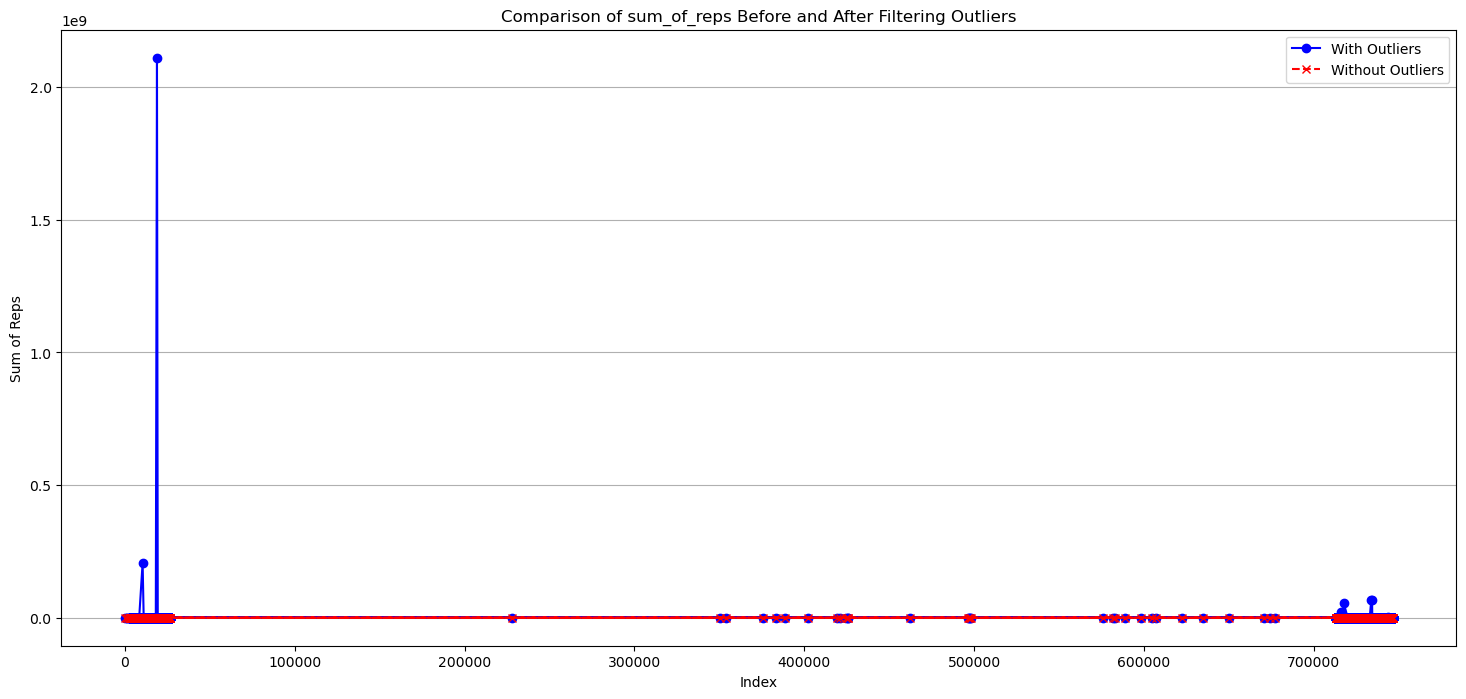

In [49]:
# Plot sum_of_reps before and after filtering outliers
plt.figure(figsize=(18, 8))

# Plot before filtering (with outliers)
plt.plot(df_series_recalculated.index, df_series_recalculated.sum_of_reps, label='With Outliers', color='blue', marker='o', linestyle='-')

# Plot after filtering (without outliers)
plt.plot(df_filtered.index, df_filtered.sum_of_reps, label='Without Outliers', color='red', marker='x', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Sum of Reps')
plt.title('Comparison of sum_of_reps Before and After Filtering Outliers')
plt.legend()
plt.grid(axis='y')
plt.show()


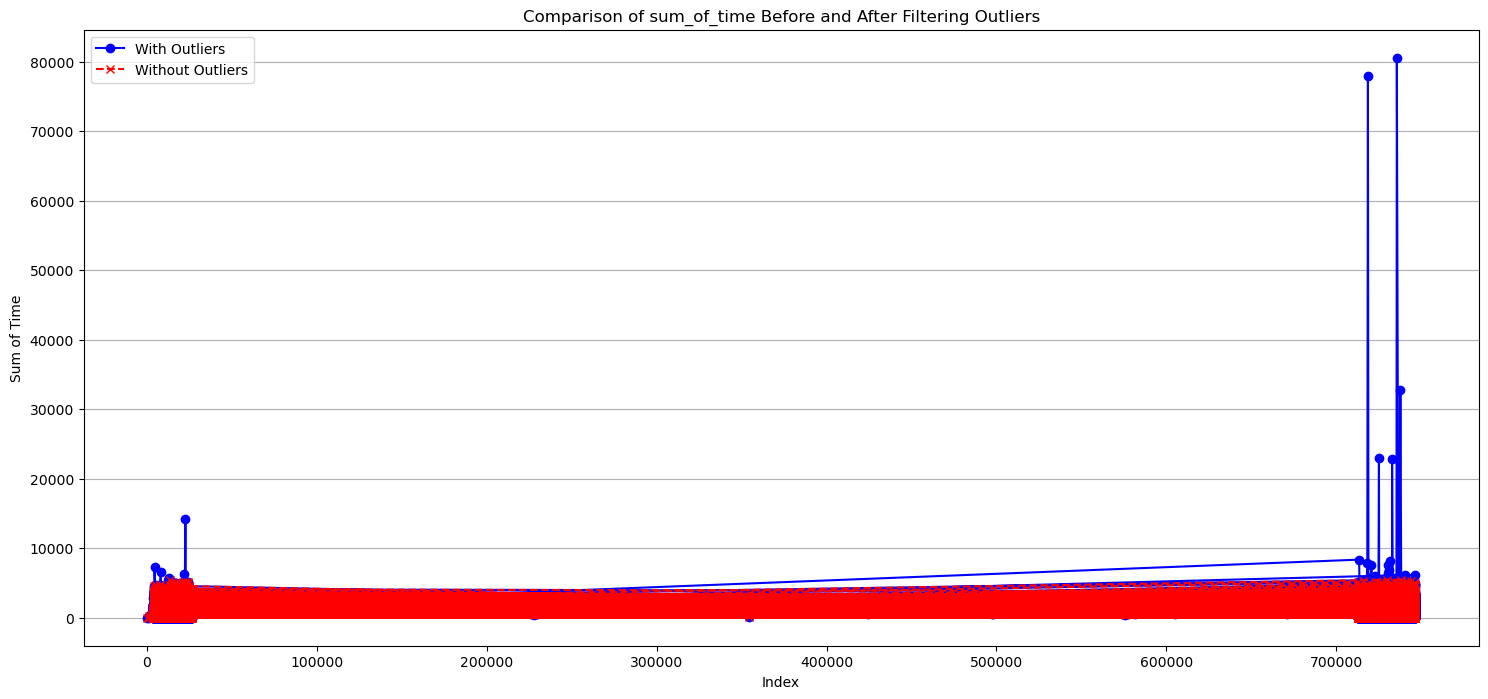

In [50]:
# Plot sum_of_reps before and after filtering outliers
plt.figure(figsize=(18, 8))

# Plot before filtering (with outliers)
plt.plot(df_series_recalculated.index, df_series_recalculated.sum_of_time, label='With Outliers', color='blue', marker='o', linestyle='-')

# Plot after filtering (without outliers)
plt.plot(df_filtered.index, df_filtered.sum_of_time, label='Without Outliers', color='red', marker='x', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Sum of Time')
plt.title('Comparison of sum_of_time Before and After Filtering Outliers')
plt.legend()
plt.grid(axis='y')
plt.show()


----
----
----
----

## Statistical Analysis of the Data

### Distribution Graphs - Histograms 

#### Histogram of Series Distribution per Training Session

This chart is a histogram that shows how training sessions are distributed according to the number of series performed. Each bar represents the number of sessions that have a specific number of series, allowing for the visualization of the frequency of different amounts of series per session.

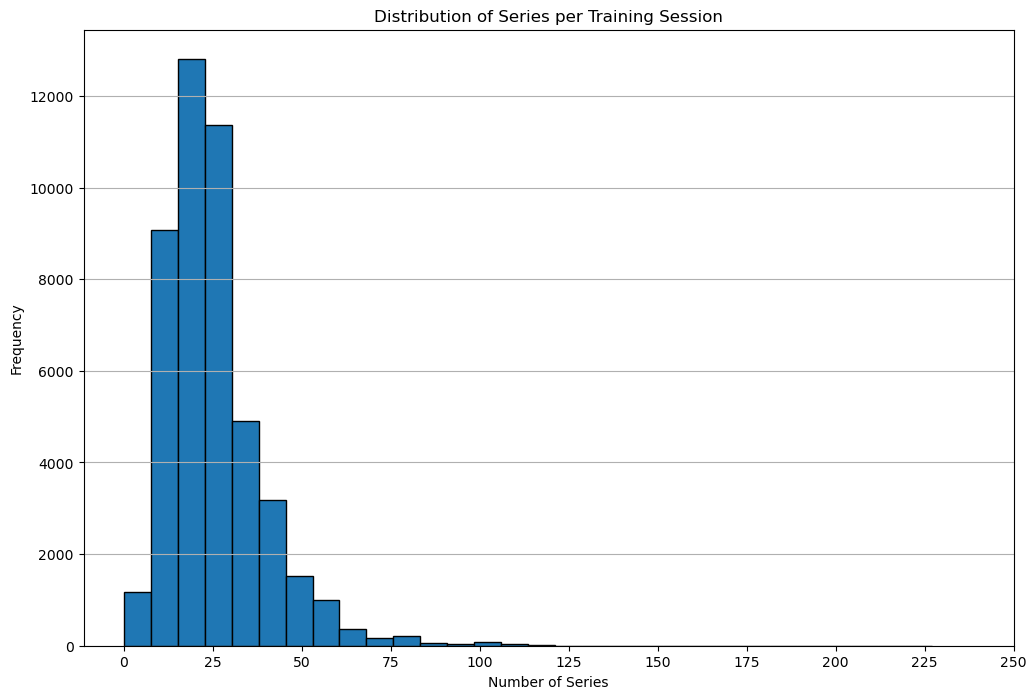

Maximum value of serie per training session: 227
Mean value of serie per training session: 24.946006431427083
Median value of serie per training session: 22.0


In [51]:
plt.figure(figsize=(12, 8))
plt.hist(df_filtered['total_count_of_series_reps'], bins=30, edgecolor='black')
plt.xlabel('Number of Series')
plt.ylabel('Frequency')
plt.title('Distribution of Series per Training Session')

max_series = df_filtered['total_count_of_series_reps'].max()
plt.xticks(np.arange(0, max_series + 25, 25))

plt.grid(axis='y')
plt.show()

print(f'Maximum value of serie per training session:',df_filtered['total_count_of_series_reps'].max())
print(f'Mean value of serie per training session:',df_filtered['total_count_of_series_reps'].mean())
print(f'Median value of serie per training session:',df_filtered['total_count_of_series_reps'].median())

#### Histogram of Repetitions Distribution per Training Session

This chart is a histogram that shows how training sessions are distributed according to the number of repetitions performed. Each bar represents the number of sessions that have a specific number of repetitions, allowing for the visualization of the frequency of different amounts of repetitions per session.

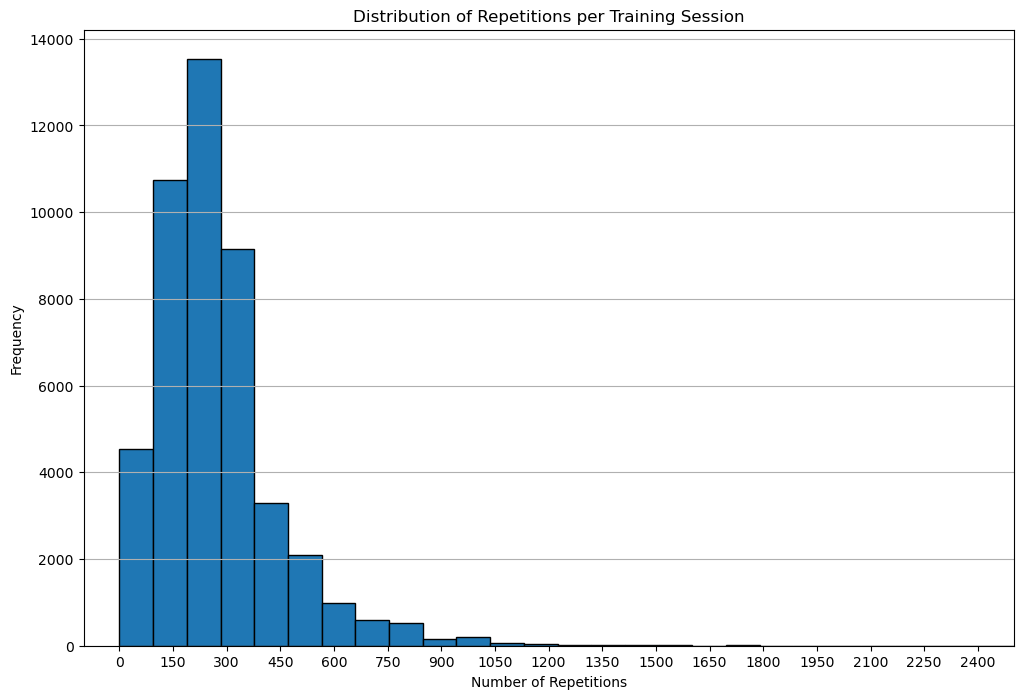

Maximum value of repetitions per training session: 4711.0
Mean value of repetitions per training session: 268.69739701025554
Median value of repetitions per training session: 240.0


In [66]:
plt.figure(figsize=(12, 8))
plt.hist(df_filtered['sum_of_reps'], bins=50, edgecolor='black')
plt.xlabel('Number of Repetitions')
plt.ylabel('Frequency')
plt.title('Distribution of Repetitions per Training Session')

max_series = df_filtered['sum_of_reps'].max()
plt.xticks(np.arange(0, max_series + 150, 150))
plt.xlim(-100, 2500)

plt.grid(axis='y')
plt.show()

print(f'Maximum value of repetitions per training session:',df_filtered['sum_of_reps'].max())
print(f'Mean value of repetitions per training session:',df_filtered['sum_of_reps'].mean())
print(f'Median value of repetitions per training session:',df_filtered['sum_of_reps'].median())

#### Histogram of the Distribution of Total Time Spent on Exercises per Training Session

The displayed graph is a histogram that shows the distribution of the total time spent on exercises per training session, measured in minutes. The x-axis represents the total time spent, while the y-axis shows the frequency of sessions that fall within each time range. The histogram helps in understanding the common duration of training sessions, with the average session time being around 22 minutes.

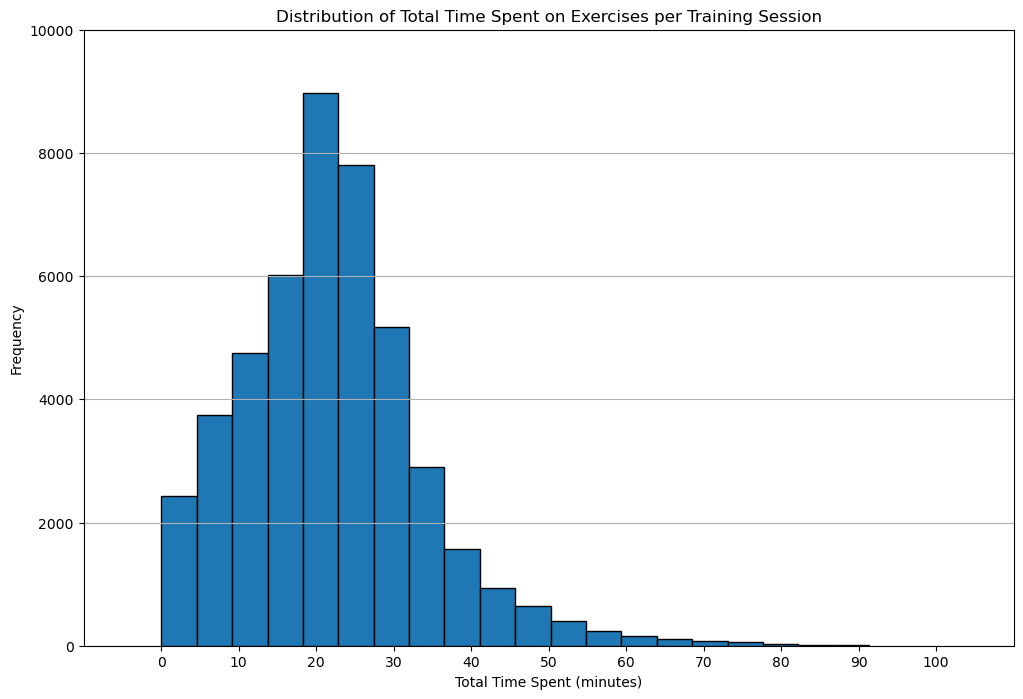

Maximum value of rest time per training session: 91.35 minutes
Mean value of rest time per training session: 21.996028159221275 minutes
Median value of rest time per training session: 21.55 minutes


In [64]:
plt.figure(figsize=(12, 8))
plt.hist(df_filtered['sum_of_time'] / 60, bins=20, edgecolor='black')
plt.xlabel('Total Time Spent (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Time Spent on Exercises per Training Session')

max_time = df_filtered['sum_of_time'].max() / 60
plt.xticks(np.arange(0, max_time + 10, 10))

plt.ylim(0, 10000)
plt.xlim(-10, 110)
plt.grid(axis='y')
plt.show()

print(f'Maximum value of rest time per training session: {df_filtered.sum_of_time.max() / 60} minutes')
print(f'Mean value of rest time per training session: {df_filtered.sum_of_time.mean() / 60} minutes')
print(f'Median value of rest time per training session: {df_filtered.sum_of_time.median() / 60} minutes')

#### Histogram of the Distribution of Rest Time per Training Session

The displayed graph is a histogram that shows the distribution of rest time per training session, measured in minutes. The x-axis represents the rest time, while the y-axis shows the frequency of sessions that fall within each rest time range. The histogram helps in understanding the common rest periods, with the average rest time being around 5.64 minutes.

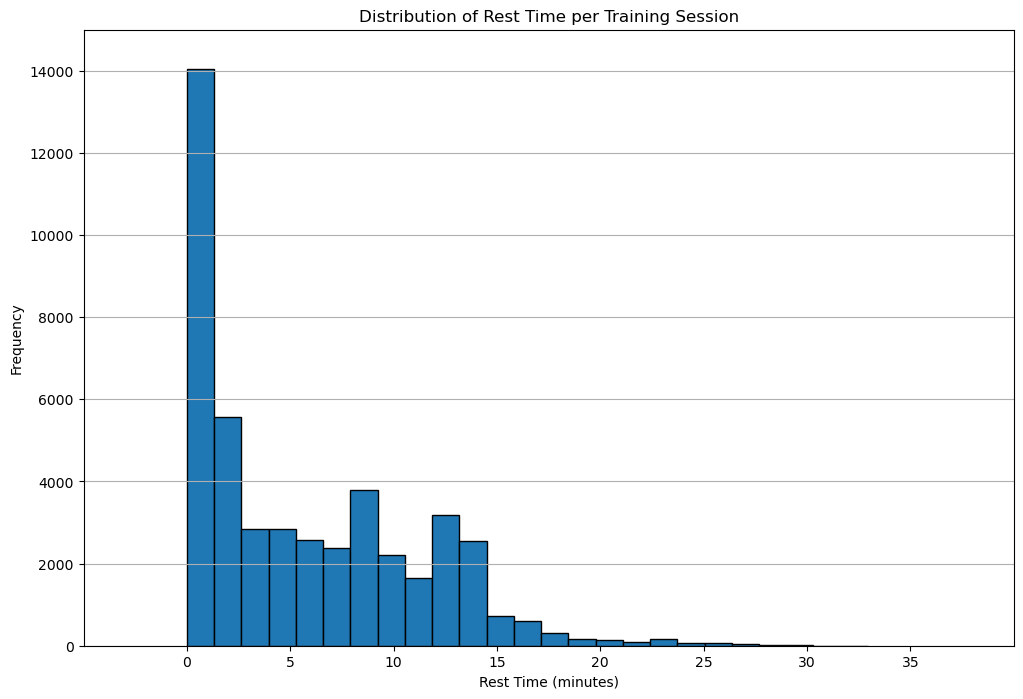

Maximum value of rest time per training session: 32.95 minutes
Mean value of rest time per training session: 5.631194594124804 minutes
Median value of rest time per training session: 4.15 minutes


In [72]:
plt.figure(figsize=(12, 8))
plt.hist(df_filtered['Rest_sum_of_time_per_exercise'] / 60, bins=25, edgecolor='black')
plt.xlabel('Rest Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Rest Time per Training Session')

max_rest_time = df_filtered['Rest_sum_of_time_per_exercise'].max() / 60
plt.xticks(np.arange(0, max_rest_time + 5, 5))

plt.ylim(0, 15000)
plt.xlim(-5, 40)
plt.grid(axis='y')
plt.show()

print(f'Maximum value of rest time per training session: {df_filtered.Rest_sum_of_time_per_exercise.max() / 60} minutes')
print(f'Mean value of rest time per training session: {df_filtered.Rest_sum_of_time_per_exercise.mean() / 60} minutes')
print(f'Median value of rest time per training session: {df_filtered.Rest_sum_of_time_per_exercise.median() / 60} minutes')

#### Distribution of Training Frequency from June 2021 to May 2022

This bar chart shows the number of training sessions conducted each month from June 2021 to May 2022. The x-axis represents each month and year, while the y-axis indicates the number of training sessions. The graph provides insight into the monthly training patterns, revealing the highest frequency of training sessions and the overall distribution throughout the specified period. The mean training frequency per month is also displayed for better understanding of the data.

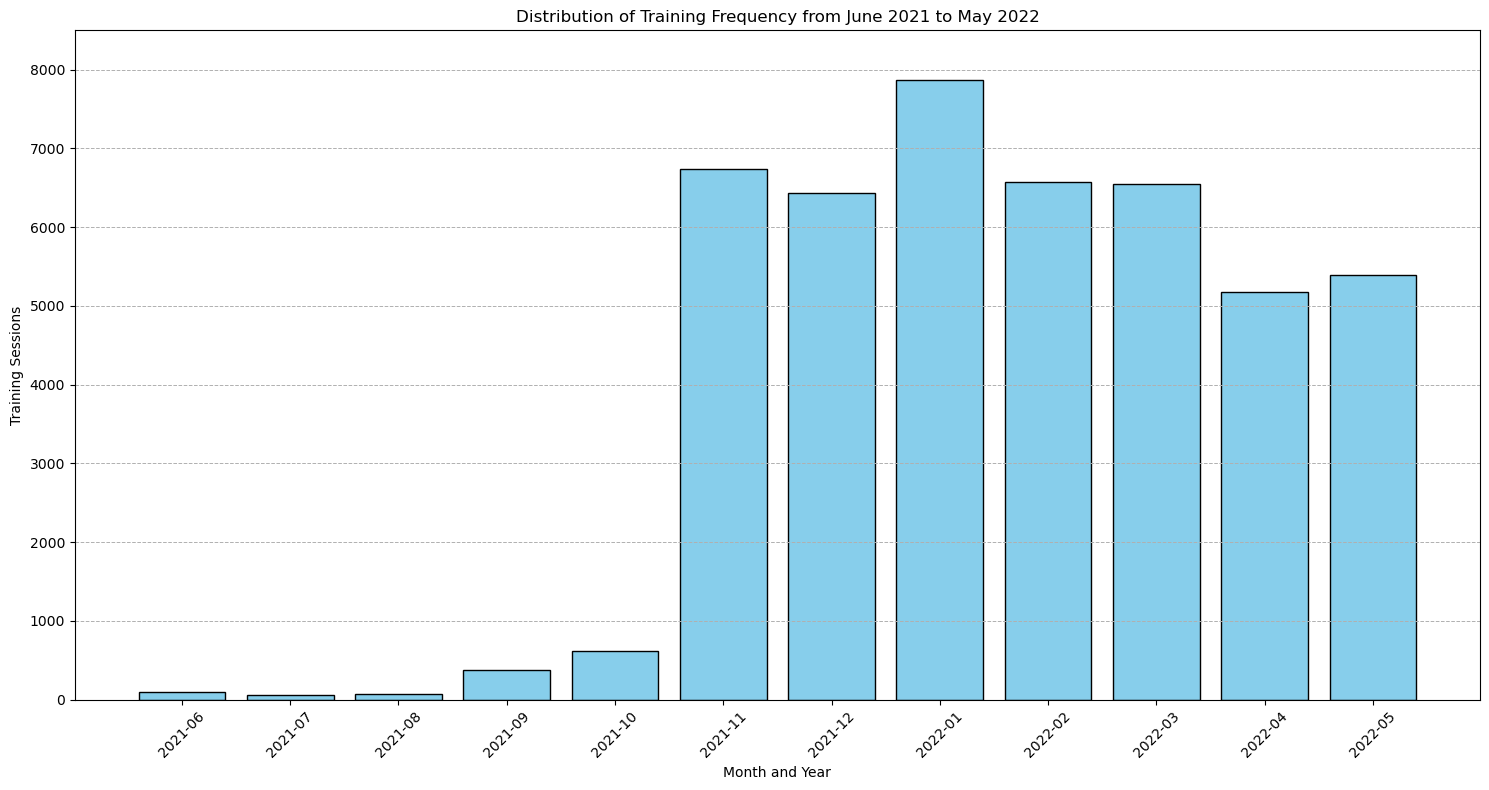

The maximum training frequency in a month is: 7873 training sessions
The mean training frequency per month is:
month
2021-06     102
2021-07      62
2021-08      69
2021-09     376
2021-10     625
2021-11    6744
2021-12    6437
2022-01    7873
2022-02    6580
2022-03    6552
2022-04    5179
2022-05    5391
Freq: M, dtype: int64


In [73]:
import calendar
import warnings
warnings.filterwarnings("ignore")

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Filter data from June 2021 to May 2022
filtered_df = df_filtered[(df_filtered['date'] >= '2021-06-01') & (df_filtered['date'] <= '2022-05-31')]

# Calculate the number of training sessions per month
filtered_df['month'] = filtered_df['date'].dt.to_period('M')
training_frequency_per_month = filtered_df.groupby('month').size()

# Plotting
plt.figure(figsize=(15, 8))
plt.bar(training_frequency_per_month.index.astype(str), training_frequency_per_month.values, edgecolor='black', color='skyblue', width=0.8)
plt.xlabel('Month and Year')
plt.ylabel('Training Sessions')
plt.title('Distribution of Training Frequency from June 2021 to May 2022')
plt.ylim(0, training_frequency_per_month.max() + 100)

# Format x-axis with month and year
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.ylim(0, 8500)
plt.tight_layout()
plt.show()

print(f'The maximum training frequency in a month is: {training_frequency_per_month.max()} training sessions')
print('The mean training frequency per month is:')
print(training_frequency_per_month)


#### Distribution of Training Frequency per Week from December 2021 to February 2022

This bar chart displays the number of training sessions conducted each week from December 2021 to February 2022. The x-axis represents each week, while the y-axis indicates the number of training sessions. The graph provides a detailed view of the weekly training patterns during these three months, showing the highest frequency of training sessions and the overall weekly distribution. The maximum and mean training frequencies per week are also calculated to give a better understanding of the training intensity during this period.

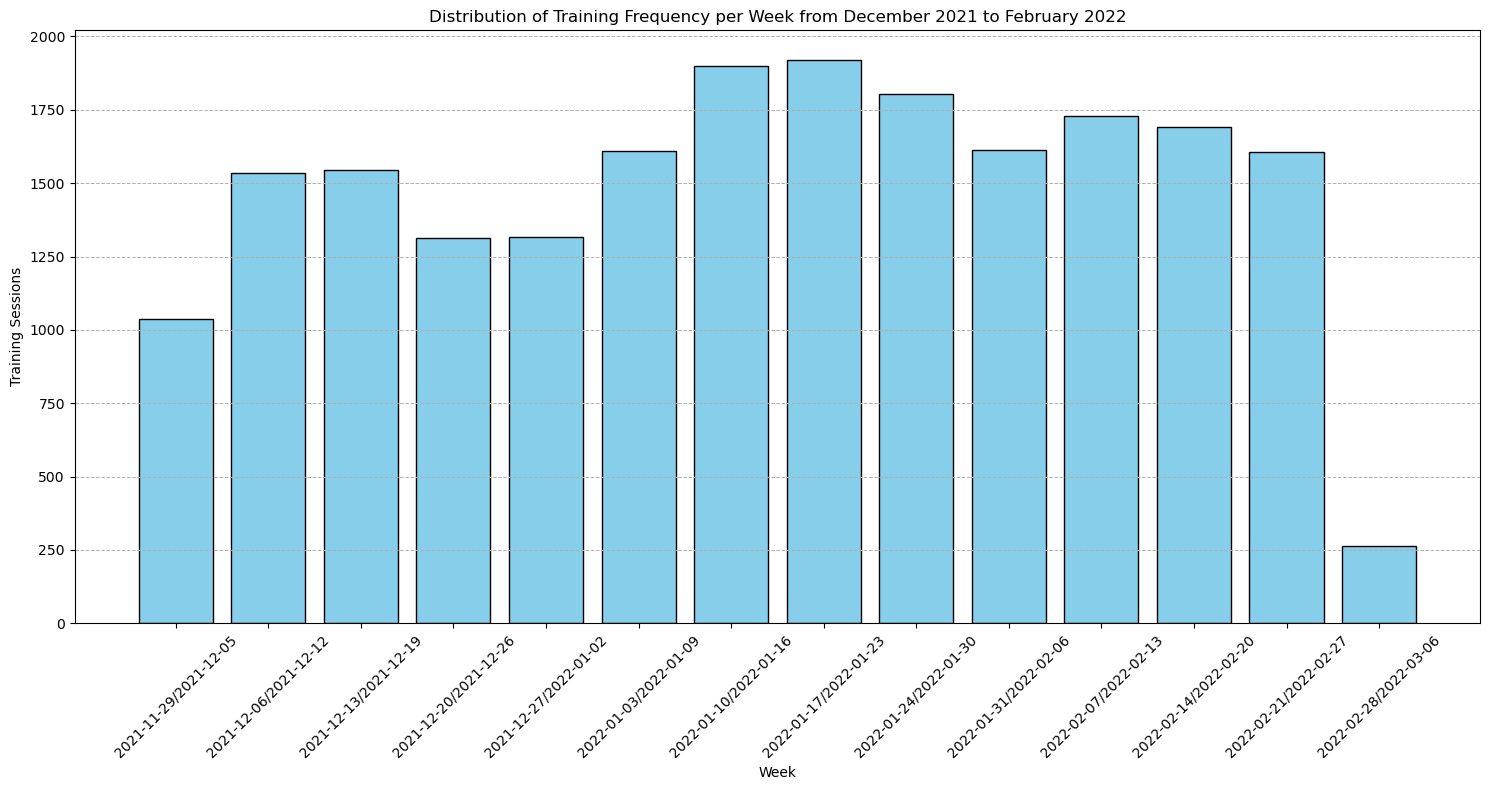

The maximum training frequency in a week is: 1921 training sessions
The mean training frequency per week is:
week
2021-11-29/2021-12-05    1036
2021-12-06/2021-12-12    1536
2021-12-13/2021-12-19    1545
2021-12-20/2021-12-26    1314
2021-12-27/2022-01-02    1317
2022-01-03/2022-01-09    1611
2022-01-10/2022-01-16    1901
2022-01-17/2022-01-23    1921
2022-01-24/2022-01-30    1803
2022-01-31/2022-02-06    1614
2022-02-07/2022-02-13    1729
2022-02-14/2022-02-20    1693
2022-02-21/2022-02-27    1607
2022-02-28/2022-03-06     263
Freq: W-SUN, dtype: int64


In [74]:
import warnings
warnings.filterwarnings("ignore")

df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Filter data for December 2021, January 2022, and February 2022
filtered_df = df_filtered[(df_filtered['date'] >= '2021-12-01') & (df_filtered['date'] <= '2022-02-28')]

# Calculate the number of training sessions per week
filtered_df['week'] = filtered_df['date'].dt.to_period('W')
training_frequency_per_week = filtered_df.groupby('week').size()

# Plotting
plt.figure(figsize=(15, 8))
plt.bar(training_frequency_per_week.index.astype(str), training_frequency_per_week.values, edgecolor='black', color='skyblue', width=0.8)
plt.xlabel('Week')
plt.ylabel('Training Sessions')
plt.title('Distribution of Training Frequency per Week from December 2021 to February 2022')
plt.ylim(0, training_frequency_per_week.max() + 100)

# Format x-axis with weeks
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

print(f'The maximum training frequency in a week is: {training_frequency_per_week.max()} training sessions')
print('The mean training frequency per week is:')
print(training_frequency_per_week)

----

### Analysis Over Time

#### Total Number of Series per Training Sessions Over Time

The graph aims to visualize the total number of series per training session over time, tracking the progression or changes in training intensity or frequency. By plotting the summed series counts against each session's date, it helps to identify trends, such as increases in workout intensity or periods of rest, as well as any seasonal or periodic patterns in training behavior. This visualization is particularly useful for monitoring training loads and planning adjustments to workout schedules based on past activity.

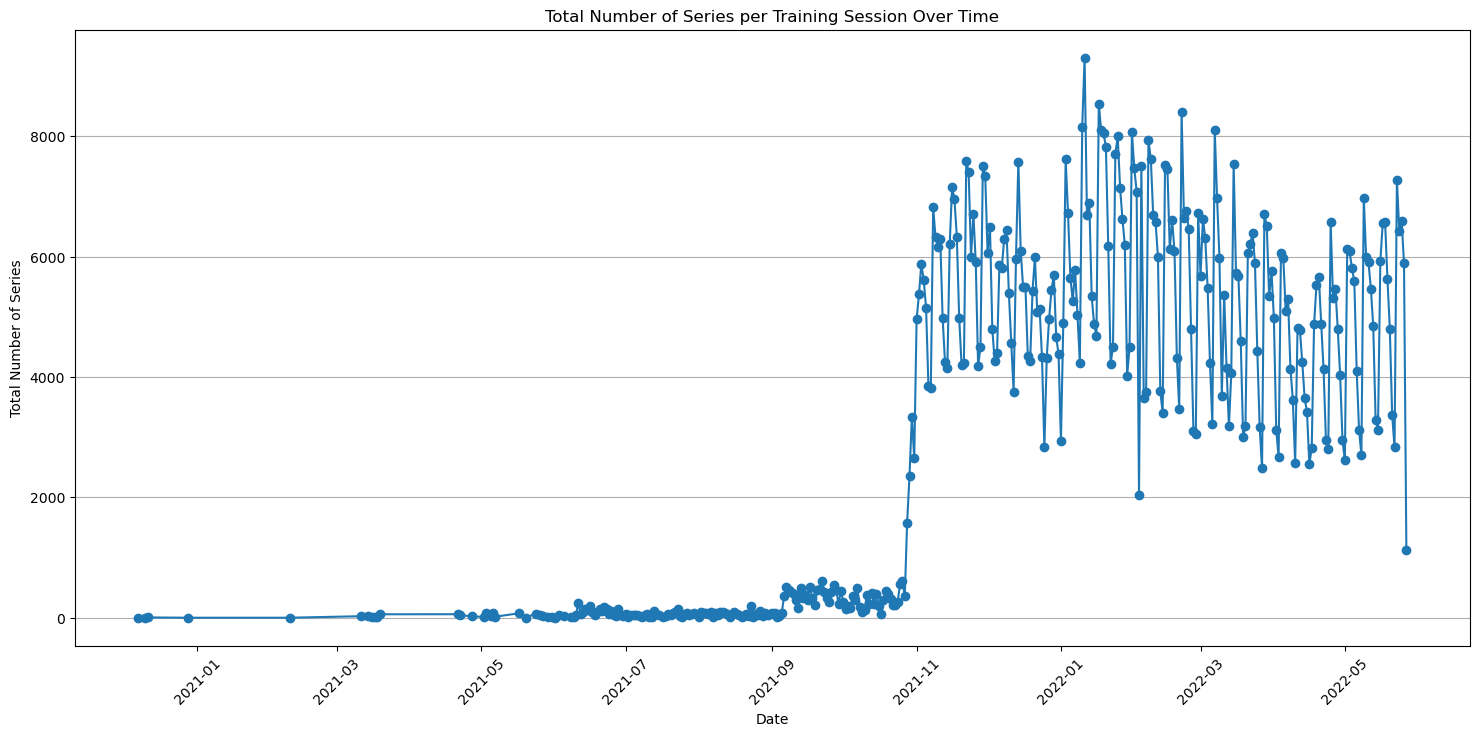

IMPORTANT ASPECT!
It is important to mention that each of the values (data points) are referring to the summatory amount of series
of all the training sessions that have been carried out during that specific day

Maximum Value for Number of Series per Training Session Over Time 9307
Mean Value for Number of Series per Training Session Over Time 3021.3552631578946
Median Value for Number of Series per Training Session Over Time 3117.5


In [86]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])  
series_over_time = df_filtered.groupby('date')['total_count_of_series_reps'].sum()

plt.figure(figsize=(18, 8))
plt.plot(series_over_time.index, series_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Number of Series')
plt.title('Total Number of Series per Training Session Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

print('IMPORTANT ASPECT!')
print('It is important to mention that each of the values (data points) are referring to the summatory amount of series')
print('of all the training sessions that have been carried out during that specific day\n')

print(f'Maximum Value for Number of Series per Training Session Over Time', series_over_time.max())
print(f'Mean Value for Number of Series per Training Session Over Time', series_over_time.mean())
print(f'Median Value for Number of Series per Training Session Over Time', series_over_time.median())

#### Total Repetitions per Training Session Over Time

This graph is designed to illustrate the total number of repetitions performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

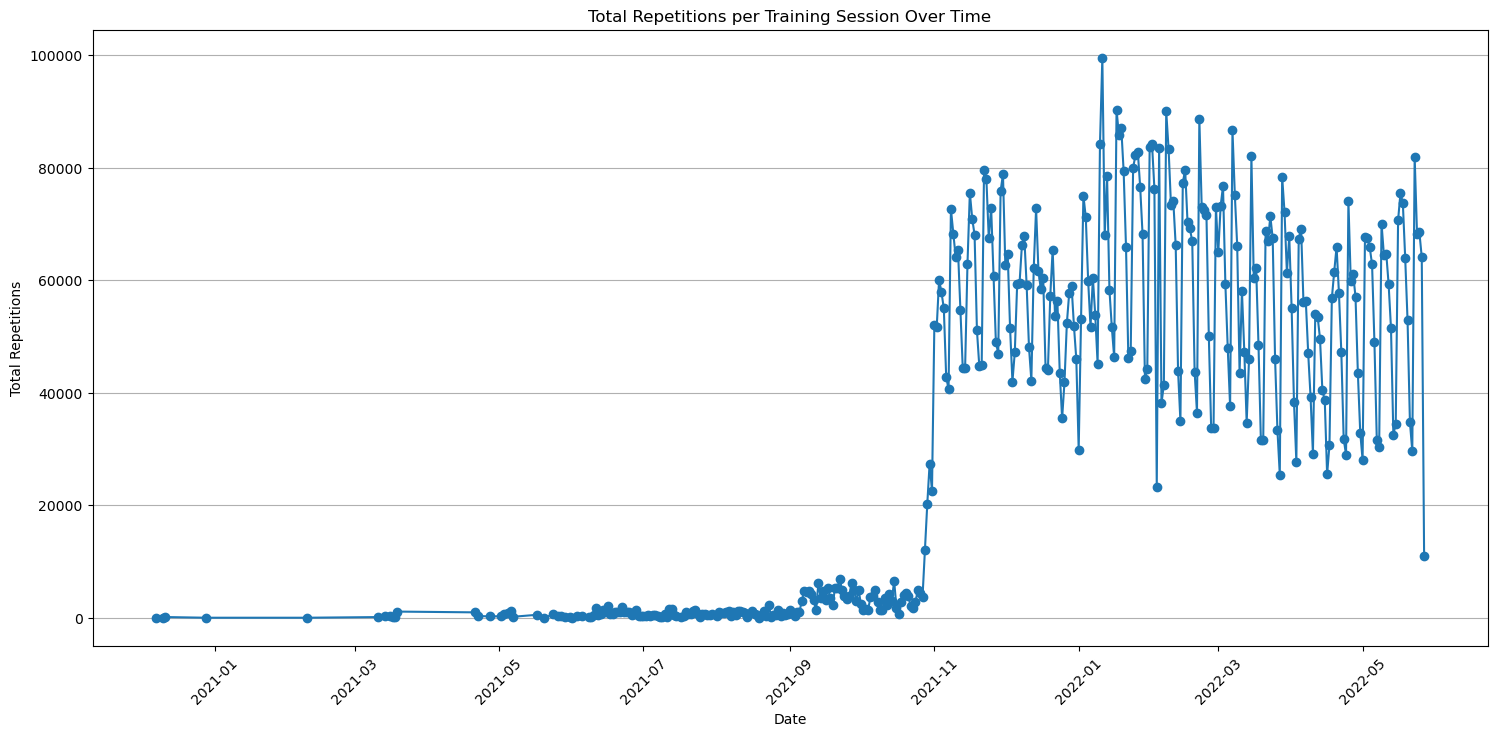

IMPORTANT ASPECT!
It is important to mention that each of the values (data points) are referring to the summatory amount of repetitions
of all the training sessions that have been carried out during that specific day

Maximum Value for Number of Repetitions per Training Session Over Time 99562.0
Mean Value for Number of Repetitions per Training Session Over Time 32543.497368421053
Median Value for Number of Repetitions per Training Session Over Time 33145.5


In [87]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])  
reps_over_time = df_filtered.groupby('date')['sum_of_reps'].sum()

plt.figure(figsize=(18, 8))
plt.plot(reps_over_time.index, reps_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Repetitions')
plt.title('Total Repetitions per Training Session Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

print('IMPORTANT ASPECT!')
print('It is important to mention that each of the values (data points) are referring to the summatory amount of repetitions')
print('of all the training sessions that have been carried out during that specific day\n')

print(f'Maximum Value for Number of Repetitions per Training Session Over Time', reps_over_time.max())
print(f'Mean Value for Number of Repetitions per Training Session Over Time', reps_over_time.mean())
print(f'Median Value for Number of Repetitions per Training Session Over Time', reps_over_time.median())


#### Total Duration per Training Session Over Time

This graph is designed to illustrate the total time performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training time intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

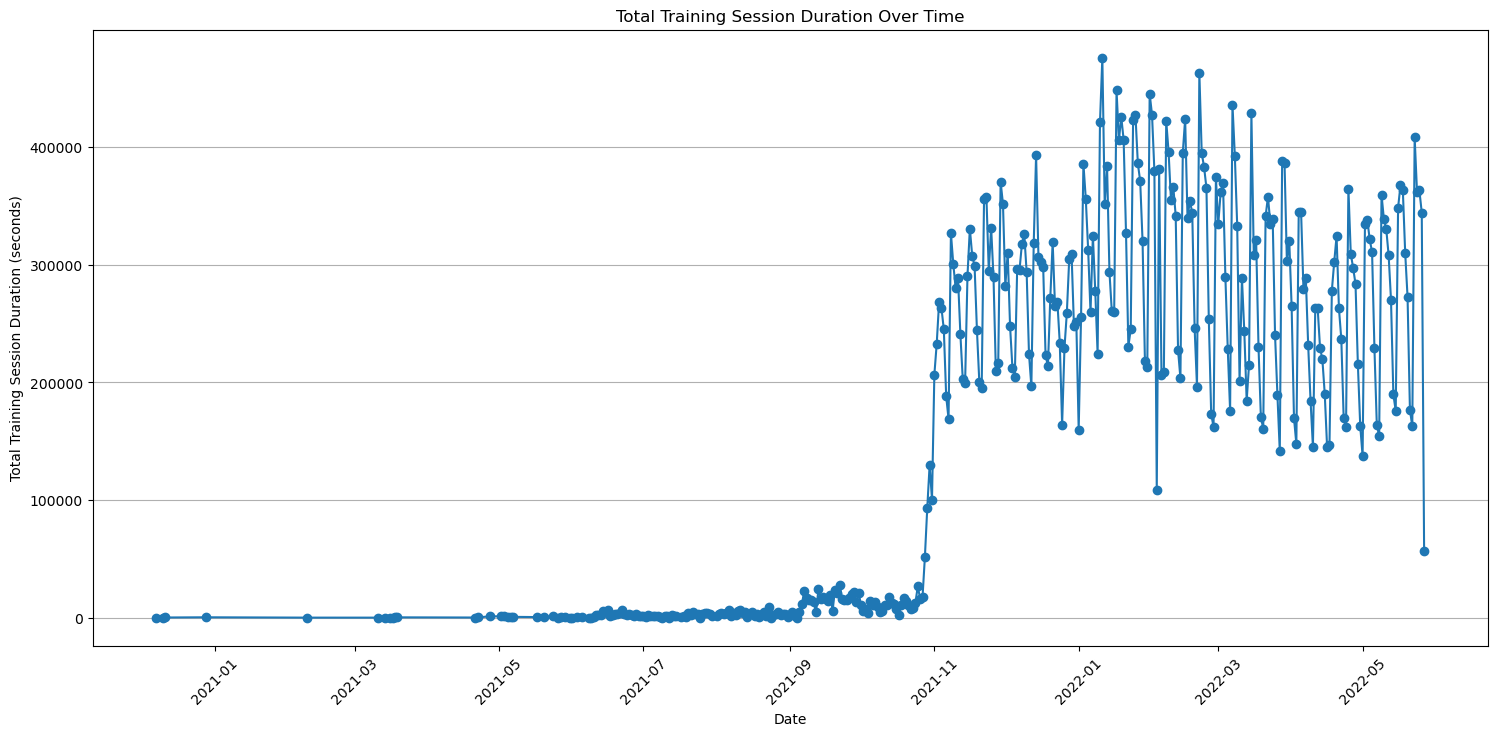

IMPORTANT ASPECT!
It is important to mention that each of the values (data points) are referring to the summatory amount of time
of all the training sessions that have been carried out during that specific day

Values per Second:
Maximum Value for Total Duration per Training Session Over Time: 476096.0 seconds
Mean Value for Total Duration per Training Session Over Time: 159843.97894736842 seconds
Median Value for Total Duration per Training Session Over Time: 169271.0 seconds

Values per Minute:
Maximum Value for Total Duration per Training Session Over Time: 7934.933333333333 minutes
Mean Value for Total Duration per Training Session Over Time: 2664.0663157894737 minutes
Median Value for Total Duration per Training Session Over Time: 2821.1833333333334 minutes

Values per Hour:
Maximum Value for Total Duration per Training Session Over Time: 132.2488888888889 hours
Mean Value for Total Duration per Training Session Over Time: 44.401105263157895 hours
Median Value for Total Duration p

In [88]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
training_session_duration_over_time = df_filtered.groupby('date')['sum_of_time'].sum()

plt.figure(figsize=(18, 8))
plt.plot(training_session_duration_over_time.index, training_session_duration_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Training Session Duration (seconds)')
plt.title('Total Training Session Duration Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

print('IMPORTANT ASPECT!')
print('It is important to mention that each of the values (data points) are referring to the summatory amount of time')
print('of all the training sessions that have been carried out during that specific day\n')

print('Values per Second:')
print(f'Maximum Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.max()} seconds')
print(f'Mean Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.mean()} seconds')
print(f'Median Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.median()} seconds')
print('\nValues per Minute:')
print(f'Maximum Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.max() / 60} minutes')
print(f'Mean Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.mean() / 60} minutes')
print(f'Median Value for Total Duration per Training Session Over Time: {training_session_duration_over_time.median() / 60} minutes')
print('\nValues per Hour:')
print(f'Maximum Value for Total Duration per Training Session Over Time: {(training_session_duration_over_time.max() / 60) / 60} hours')
print(f'Mean Value for Total Duration per Training Session Over Time: {(training_session_duration_over_time.mean() / 60) / 60} hours')
print(f'Median Value for Total Duration per Training Session Over Time: {(training_session_duration_over_time.median() / 60) / 60} hours')


#### Total Rest Time per Training Session Over Time

This graph is designed to illustrate the total rest time performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training rest time intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

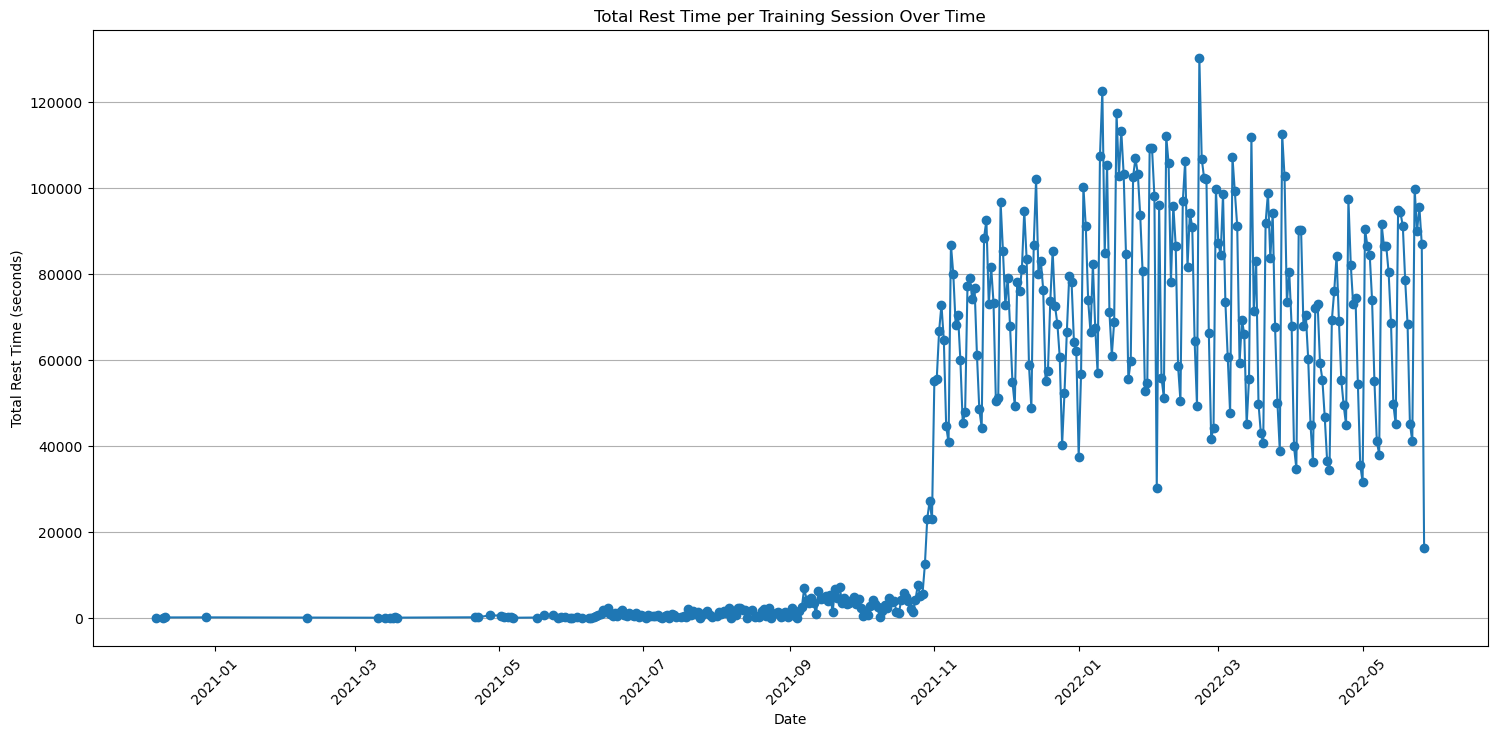

IMPORTANT ASPECT!
It is important to mention that each of the values (data points) are referring to the summatory amount of rest time
of all the training sessions that have been carried out during that specific day

Values per Second:
Maximum Value for Rest Time per Training Session Over Time: 130362.0 seconds
Mean Value for Rest Time per Training Session Over Time: 40921.594736842104 seconds
Median Value for Rest Time per Training Session Over Time: 42284.0 seconds

Values per Minute:
Maximum Value for Rest Time per Training Session Over Time: 2172.7 minutes
Mean Value for Rest Time per Training Session Over Time: 682.0265789473684 minutes
Median Value for Rest Time per Training Session Over Time: 704.7333333333333 minutes

Values per Hour:
Maximum Value for Rest Time per Training Session Over Time: 11.745555555555557 hours
Mean Value for Rest Time per Training Session Over Time: 11.745555555555557 hours
Median Value for Rest Time per Training Session Over Time: 11.745555555555557 hou

In [89]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
rest_time_over_time = df_filtered.groupby('date')['Rest_sum_of_time_per_exercise'].sum()

plt.figure(figsize=(18, 8))
plt.plot(rest_time_over_time.index, rest_time_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Rest Time (seconds)')
plt.title('Total Rest Time per Training Session Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

print('IMPORTANT ASPECT!')
print('It is important to mention that each of the values (data points) are referring to the summatory amount of rest time')
print('of all the training sessions that have been carried out during that specific day\n')

print('Values per Second:')
print(f'Maximum Value for Rest Time per Training Session Over Time: {rest_time_over_time.max()} seconds')
print(f'Mean Value for Rest Time per Training Session Over Time: {rest_time_over_time.mean()} seconds')
print(f'Median Value for Rest Time per Training Session Over Time: {rest_time_over_time.median()} seconds')
print('\nValues per Minute:')
print(f'Maximum Value for Rest Time per Training Session Over Time: {rest_time_over_time.max() / 60} minutes')
print(f'Mean Value for Rest Time per Training Session Over Time: {rest_time_over_time.mean() / 60} minutes')
print(f'Median Value for Rest Time per Training Session Over Time: {rest_time_over_time.median() / 60} minutes')
print('\nValues per Hour:')
print(f'Maximum Value for Rest Time per Training Session Over Time: {(rest_time_over_time.median() / 60) / 60} hours')
print(f'Mean Value for Rest Time per Training Session Over Time: {(rest_time_over_time.median() / 60) / 60} hours')
print(f'Median Value for Rest Time per Training Session Over Time: {(rest_time_over_time.median() / 60) / 60} hours')

---

### Box Plot Analysis - Detection of Outliers

#### Box Plot of Total Series per Training Session

This box plot visualizes the distribution of the total number of series performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the number of series per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low numbers of series in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

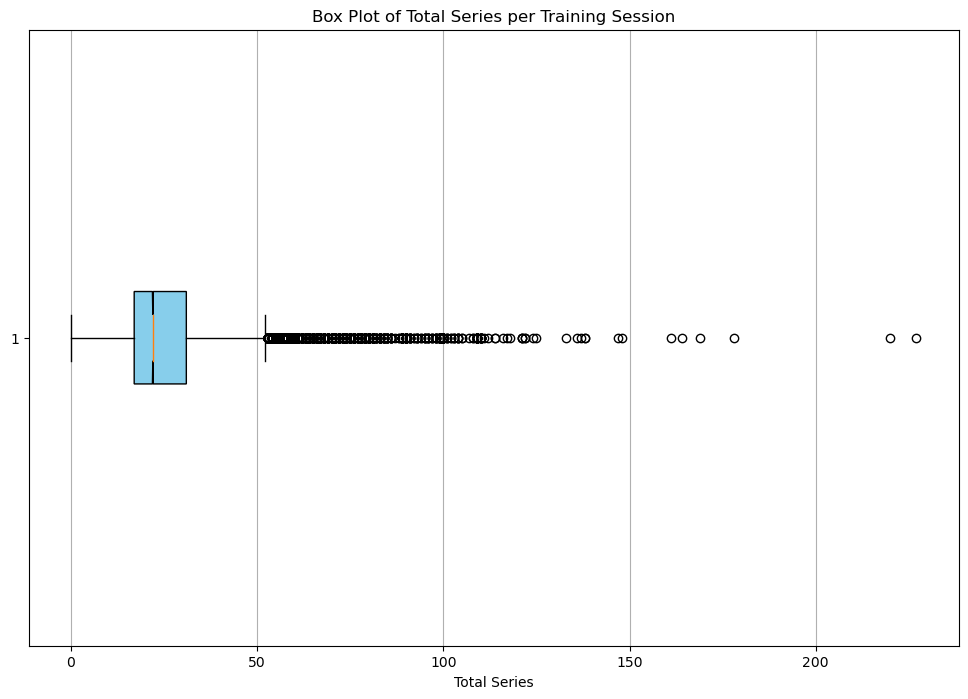

The maximum number of series per training session is: 227 series
The mean number of series per training session is: 24.946006431427083 series
The median number of series per training session is: 22.0 series


In [90]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
total_count_of_series_reps = df_filtered['total_count_of_series_reps']

plt.figure(figsize=(12, 8))
plt.boxplot(total_count_of_series_reps, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Total Series')
plt.title('Box Plot of Total Series per Training Session')
plt.grid(axis='x')
plt.show()

print(f'The maximum number of series per training session is:', total_count_of_series_reps.max(), 'series')
print(f'The mean number of series per training session is:', total_count_of_series_reps.mean(), 'series')
print(f'The median number of series per training session is:', total_count_of_series_reps.median(), 'series')

#### Box Plot of Total Repetitions per Training Session

This box plot visualizes the distribution of the total number of repetitions performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the number of repetitions per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low numbers of repetitions in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

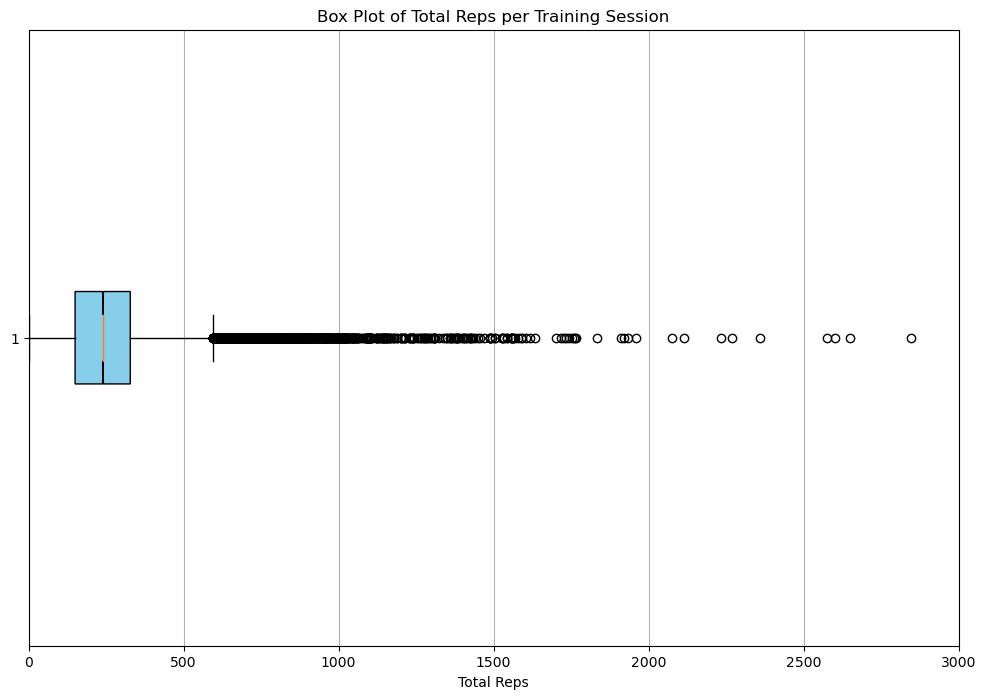

The maximum number of repetitions per training session is: 4711.0 reps
The mean number of repetitions per training session is: 268.69739701025554 reps
The median number of repetitions per training session is: 240.0 reps

It is important to know that there exists one more outlier in the graph, at 4711, but it has to be added an x-axis limit 
in order to have a better interpretability of the graph displayed.


In [93]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
sum_of_reps = df_filtered['sum_of_reps']

plt.figure(figsize=(12, 8))
plt.boxplot(sum_of_reps, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Total Reps')
plt.title('Box Plot of Total Reps per Training Session')
plt.xlim(0,3000)
plt.grid(axis='x')
plt.show()

print(f'The maximum number of repetitions per training session is:', sum_of_reps.max(), 'reps')
print(f'The mean number of repetitions per training session is:', sum_of_reps.mean(), 'reps')
print(f'The median number of repetitions per training session is:', sum_of_reps.median(), 'reps')
print('\nIt is important to know that there exists one more outlier in the graph, at 4711, but it has to be added an x-axis limit \nin order to have a better interpretability of the graph displayed.')

#### Box Plot of Total Time per Training Session

This box plot visualizes the distribution of the total time performed in each training session (this includes time doing exercise and rest time). The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the time per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low times in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

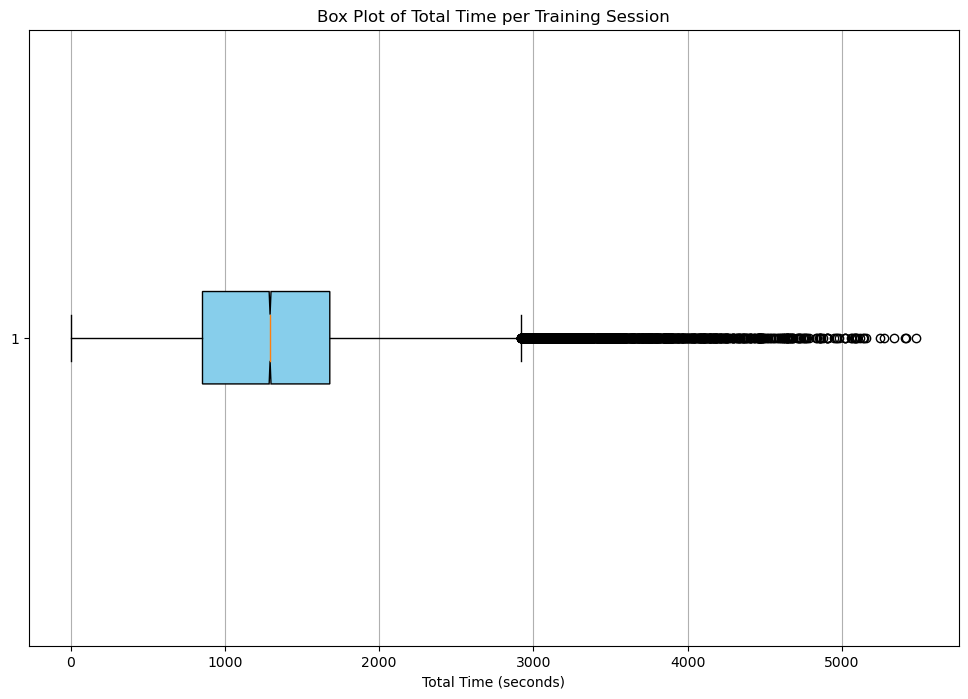

Training Session Time in Seconds:
The maximum time of a training session is: 5481.0 seconds
The mean time of a training session is: 1319.7616895532765 seconds
The median time of a training session is: 1293.0 seconds

Training Session Time in Minutes:
The maximum time of a training session is: 91.35 minutes
The mean time of a training session is: 21.996028159221275 minutes
The median time of a training session is: 21.55 minutes


In [95]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
sum_of_time = df_filtered['sum_of_time']

plt.figure(figsize=(12, 8))
plt.boxplot(sum_of_time, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Total Time (seconds)')
plt.title('Box Plot of Total Time per Training Session')
plt.grid(axis='x')
plt.show()

print('Training Session Time in Seconds:')
print(f'The maximum time of a training session is:', sum_of_time.max(), 'seconds')
print(f'The mean time of a training session is:', sum_of_time.mean(), 'seconds')
print(f'The median time of a training session is:', sum_of_time.median(), 'seconds')
print('\nTraining Session Time in Minutes:')
print(f'The maximum time of a training session is:', sum_of_time.max() / 60, 'minutes')
print(f'The mean time of a training session is:', sum_of_time.mean() / 60, 'minutes')
print(f'The median time of a training session is:', sum_of_time.median() / 60, 'minutes')

#### Box Plot of Rest Time per Training Session

This box plot visualizes the distribution of the total rest time performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the rest time per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low rest times in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

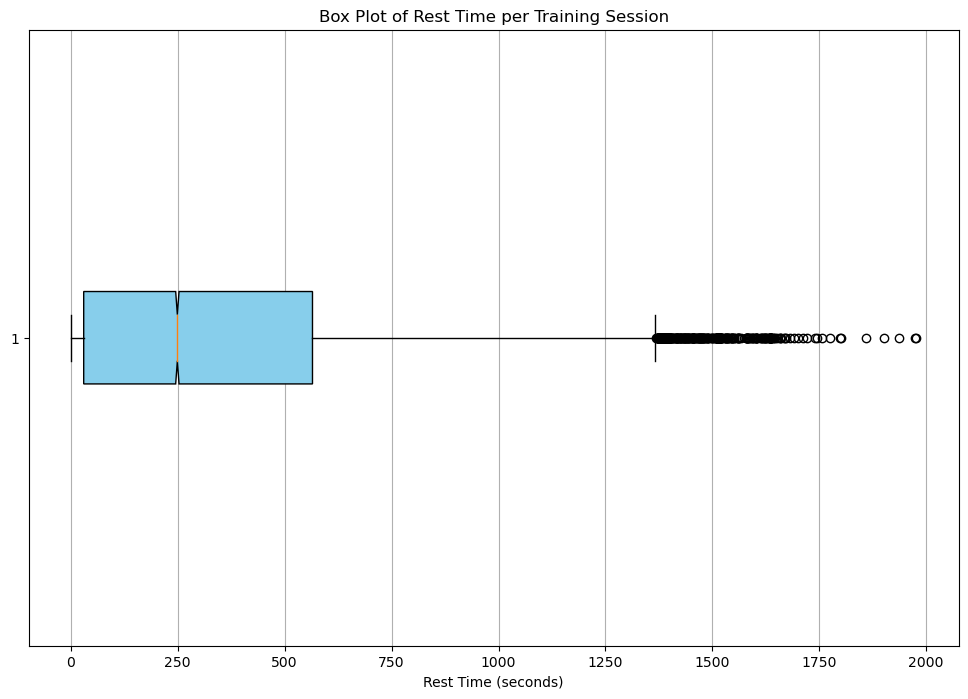

Rest Time in Seconds
The maximum rest time is: 1977.0 seconds
The mean rest time is: 337.87167564748825 seconds
The median rest time is: 249.0 seconds

Rest Time in Minutes
The maximum rest time is: 32.95 minutes
The mean rest time is: 5.631194594124804 minutes
The median rest time is: 4.15 minutes


In [97]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
rest_time = df_filtered['Rest_sum_of_time_per_exercise']

plt.figure(figsize=(12, 8))
plt.boxplot(rest_time, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Rest Time (seconds)')
plt.title('Box Plot of Rest Time per Training Session')
plt.grid(axis='x')
plt.show()

print('Rest Time in Seconds')
print(f'The maximum rest time is:', rest_time.max(), 'seconds')
print(f'The mean rest time is:', rest_time.mean(), 'seconds')
print(f'The median rest time is:', rest_time.median(), 'seconds')
print('\nRest Time in Minutes')
print(f'The maximum rest time is:', rest_time.max() / 60, 'minutes')
print(f'The mean rest time is:', rest_time.mean() / 60, 'minutes')
print(f'The median rest time is:', rest_time.median() / 60, 'minutes')

----

### Additional Analysis

#### Training Session with Highest Number of Series

This graph aims to highlight the training sessions with the highest number of series performed. By displaying the top 10 sessions with the most series, it provides insight into the most intensive training sessions. The y-axis represents the session IDs, and the x-axis shows the number of series, allowing for easy identification of the sessions with the highest volume of work.

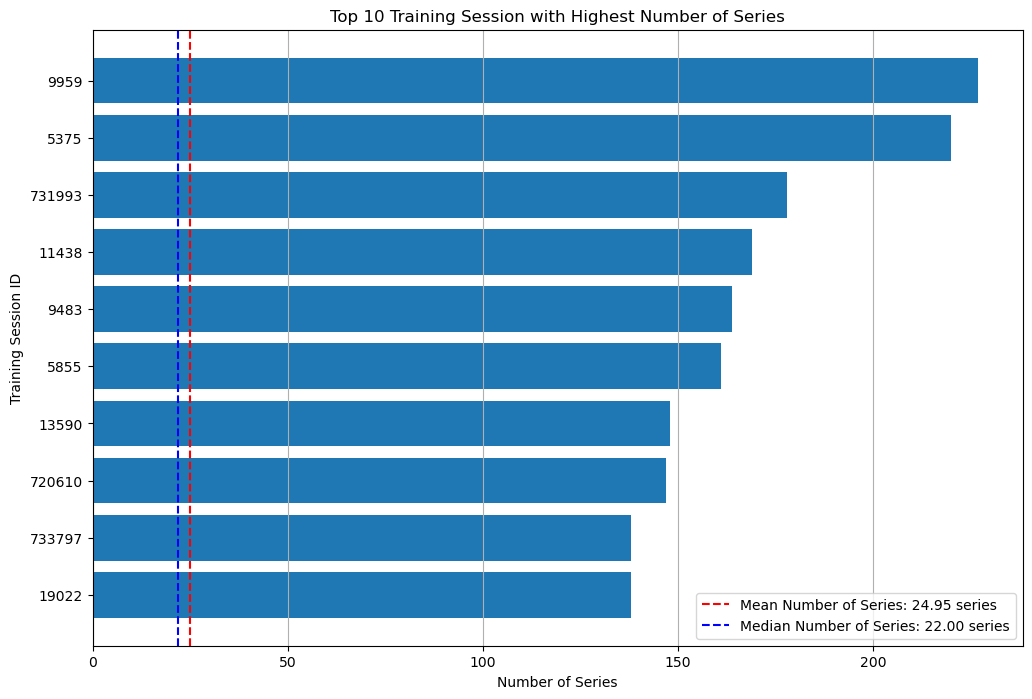

Top 10 Training Session with Highest Number of Series:
9959      227
5375      220
731993    178
11438     169
9483      164
5855      161
13590     148
720610    147
733797    138
19022     138
Name: total_count_of_series_reps, dtype: int64


In [98]:
# Filter Maximum Values
top_10_values = df_filtered['total_count_of_series_reps'].nlargest(10)

mean_total_count_of_series_reps = df_filtered['total_count_of_series_reps'].mean()
median_total_count_of_series_rep = df_filtered['total_count_of_series_reps'].median()

plt.figure(figsize=(12, 8))
plt.barh(range(10), top_10_values.values)
plt.yticks(range(10), top_10_values.index)
plt.axvline(mean_total_count_of_series_reps, color='r', linestyle='--', label=f'Mean Number of Series: {mean_total_count_of_series_reps:.2f} series')
plt.axvline(median_total_count_of_series_rep, color='b', linestyle='--', label=f'Median Number of Series: {median_total_count_of_series_rep:.2f} series')
plt.xlabel('Number of Series')
plt.ylabel('Training Session ID')
plt.title('Top 10 Training Session with Highest Number of Series')
plt.grid(axis='x')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()

print('Top 10 Training Session with Highest Number of Series:')
print(top_10_values)

#### Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises & Bottom 10 Exercises 

This violin plot visualizes the efficiency of different exercises, measured as the number of repetitions performed per second. It includes the top 10 exercises with the highest average efficiency. The plot aims to:

- **Show Distribution**: Highlight the spread and density of efficiency values for each exercise.
- **Identify Patterns**: Reveal any patterns or trends in how efficiently different exercises are performed.
- **Compare Exercises**: Allow easy comparison of efficiency across the top 10 exercises.
- **Highlight Variability**: Indicate the variability and consistency in exercise efficiency, with quartile lines providing additional context.

This visualization helps in understanding which exercises are performed more efficiently and how the efficiency varies for each exercise.

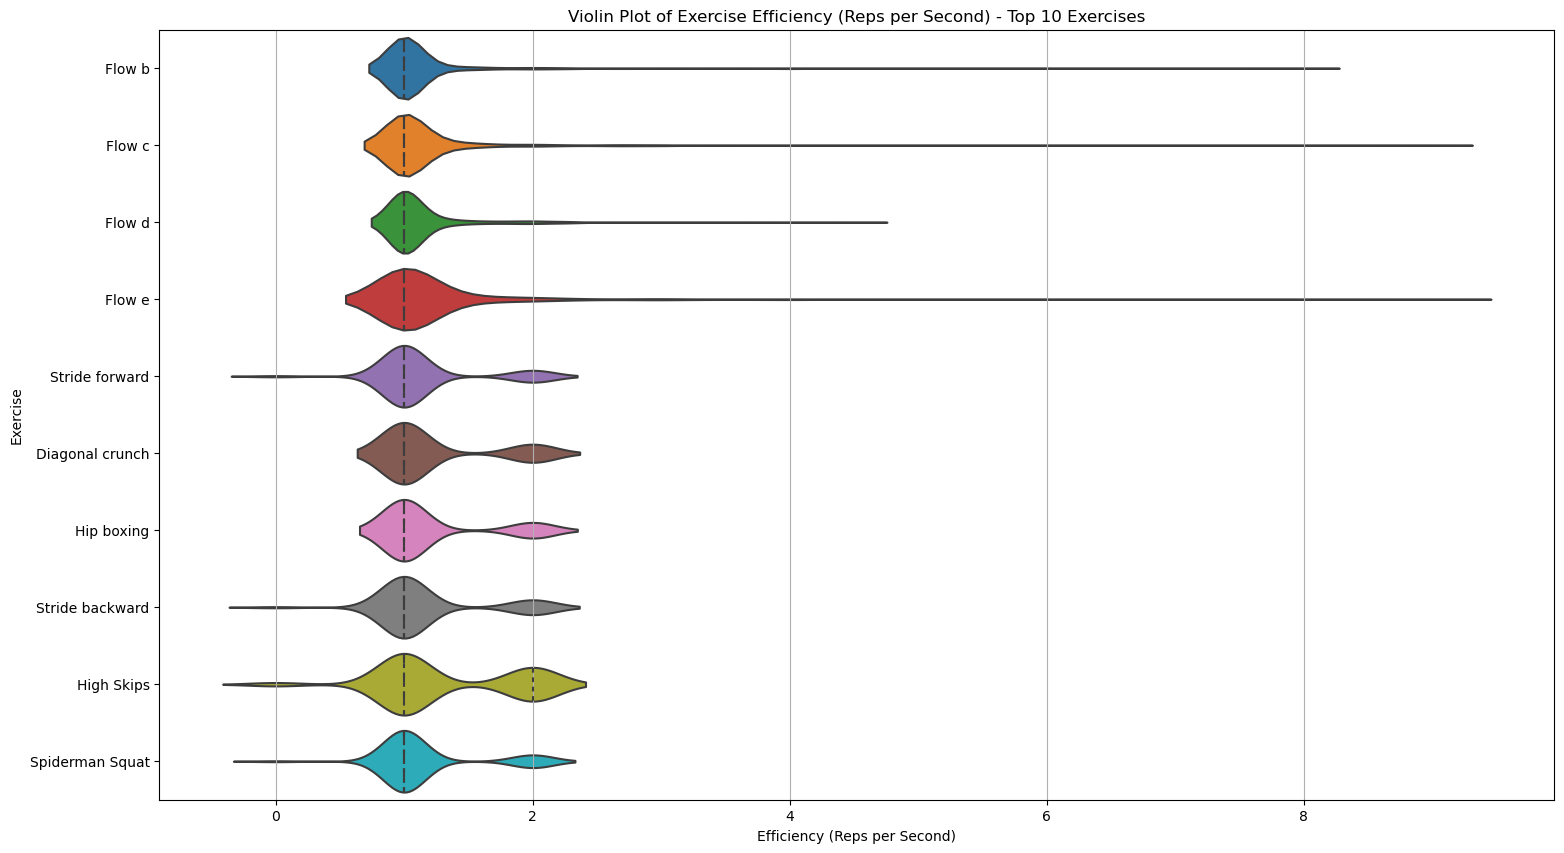

Top 10 Exercise - Efficiency
------------------------------------
Maximum Efficiency:
Exercise      Stride forward
Efficiency               9.0
dtype: object

Mean Efficiency:
Efficiency    1.16013
dtype: float64

Minimum Efficiency:
Exercise      Diagonal crunch
Efficiency                0.0
dtype: object


In [99]:
# Calculate Exercise Efficiency (Reps per Second)
efficiency_data = []

# Loop through each exercise column ending with '_reps' and not 'sum_of_reps'
for col in df_filtered.columns:
    if col.endswith('_reps') and col != 'sum_of_reps':
        exercise_name = col.replace('_reps', '')
        # Identify time column
        time_col = exercise_name + '_time'
        if time_col in df_filtered.columns:
            reps = df_filtered[col]
            time = df_filtered[time_col]
            # Calculate efficiency
            efficiency = reps / time
            efficiency_data.append(pd.DataFrame({'Exercise': [exercise_name] * len(efficiency), 'Efficiency': efficiency}))

# Combine all efficiency data into a single DataFrame
efficiency_df = pd.concat(efficiency_data, ignore_index=True)

# Drop rows with NaN values in Efficiency
efficiency_df = efficiency_df.dropna(subset=['Efficiency'])

# Calculate the mean efficiency for each exercise
mean_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].mean()

# Get the top 10 exercises by mean efficiency
top_10_exercises = mean_efficiency.nlargest(10).index

# Filter the efficiency data to include only the top 10 exercises
filtered_efficiency_df = efficiency_df[efficiency_df['Exercise'].isin(top_10_exercises)]

# Create a violin plot for Exercise Efficiency
plt.figure(figsize=(18, 10))
sns.violinplot(data=filtered_efficiency_df, x='Efficiency', y='Exercise', scale='width', inner='quartile')
plt.xlabel('Efficiency (Reps per Second)')
plt.ylabel('Exercise')
plt.title('Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises')
plt.grid(axis='x')
plt.show()

print('Top 10 Exercise - Efficiency')
print('------------------------------------')
print('Maximum Efficiency:')
print(filtered_efficiency_df.max())
print('\nMean Efficiency:')
print(filtered_efficiency_df.mean())
print('\nMinimum Efficiency:') 
print(filtered_efficiency_df.min())

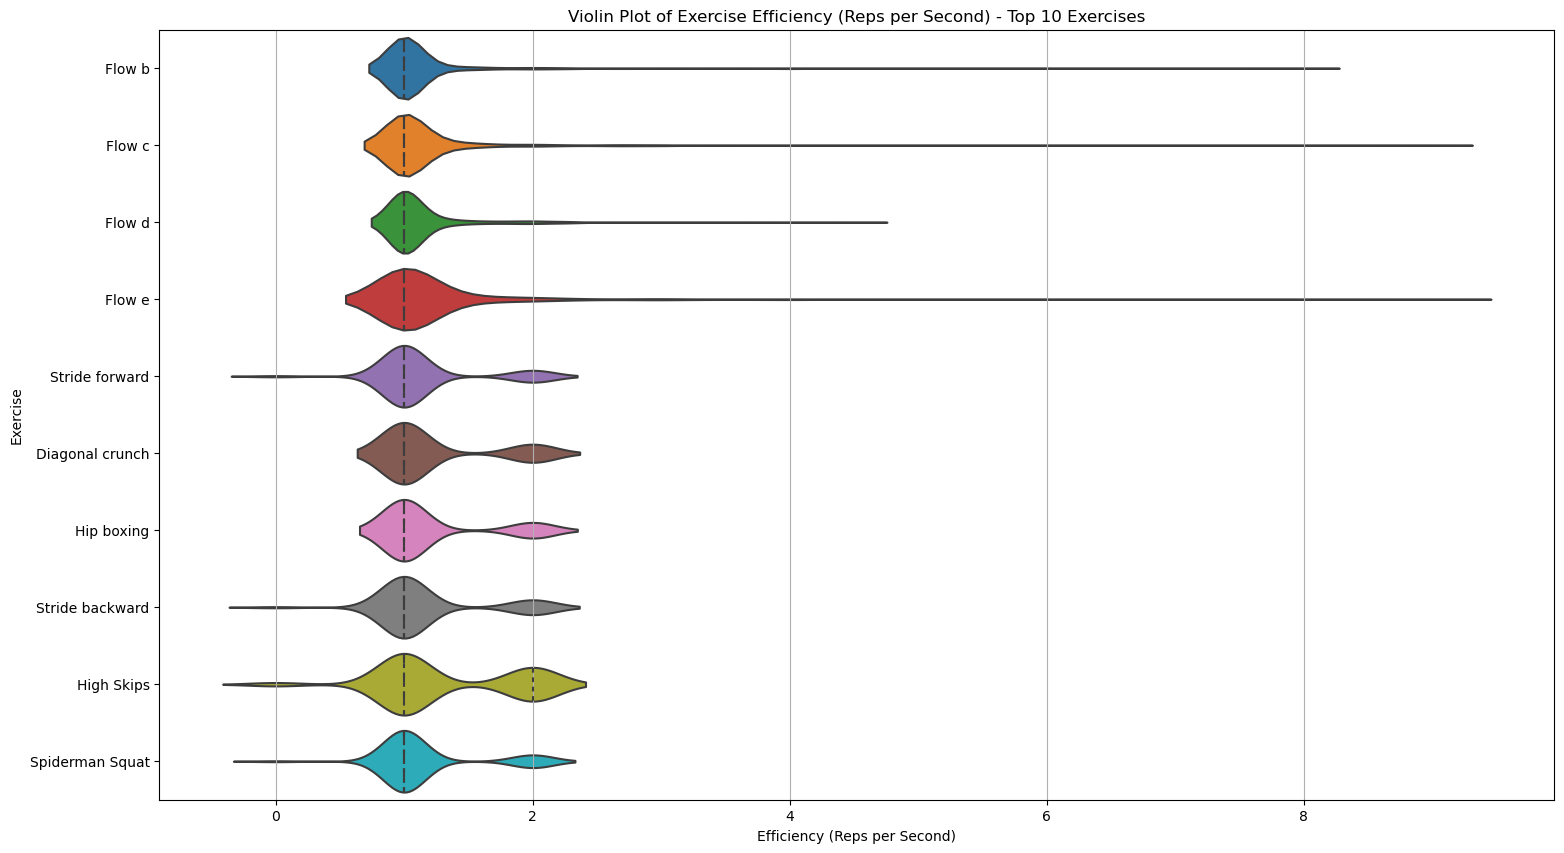

Top 10 Exercises by Mean Efficiency
------------------------------------
1. Exercise: High Skips, Mean Efficiency: 1.3076923076923077
2. Exercise: Diagonal crunch, Mean Efficiency: 1.2272727272727273
3. Exercise: Hip boxing, Mean Efficiency: 1.2028985507246377
4. Exercise: Flow e, Mean Efficiency: 1.2010958358238693
5. Exercise: Stride backward, Mean Efficiency: 1.1764705882352942
6. Exercise: Spiderman Squat, Mean Efficiency: 1.1566265060240963
7. Exercise: Stride forward, Mean Efficiency: 1.1428571428571428
8. Exercise: Flow c, Mean Efficiency: 1.1411215228665723
9. Exercise: Flow d, Mean Efficiency: 1.1346063177746346
10. Exercise: Flow b, Mean Efficiency: 1.1271070869662418

Maximum Efficiency:
Exercise
Diagonal crunch    2.0
Flow b             8.0
Flow c             9.0
Flow d             4.5
Flow e             9.0
High Skips         2.0
Hip boxing         2.0
Spiderman Squat    2.0
Stride backward    2.0
Stride forward     2.0
Name: Efficiency, dtype: float64

Mean Efficiency:
Ex

In [100]:
# Calculate Exercise Efficiency (Reps per Second)
efficiency_data = []

# Loop through each exercise column ending with '_reps' and not 'sum_of_reps'
for col in df_filtered.columns:
    if col.endswith('_reps') and col != 'sum_of_reps':
        exercise_name = col.replace('_reps', '')
        # Identify time column
        time_col = exercise_name + '_time'
        if time_col in df_filtered.columns:
            reps = df_filtered[col]
            time = df_filtered[time_col]
            # Calculate efficiency
            efficiency = reps / time
            efficiency_data.append(pd.DataFrame({'Exercise': [exercise_name] * len(efficiency), 'Efficiency': efficiency}))

# Combine all efficiency data into a single DataFrame
efficiency_df = pd.concat(efficiency_data, ignore_index=True)

# Drop rows with NaN values in Efficiency
efficiency_df = efficiency_df.dropna(subset=['Efficiency'])

# Calculate the mean efficiency for each exercise
mean_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].mean()

# Get the top 10 exercises by mean efficiency
top_10_exercises = mean_efficiency.nlargest(10).index

# Filter the efficiency data to include only the top 10 exercises
filtered_efficiency_df = efficiency_df[efficiency_df['Exercise'].isin(top_10_exercises)]

# Create a violin plot for Exercise Efficiency
plt.figure(figsize=(18, 10))
sns.violinplot(data=filtered_efficiency_df, x='Efficiency', y='Exercise', scale='width', inner='quartile')
plt.xlabel('Efficiency (Reps per Second)')
plt.ylabel('Exercise')
plt.title('Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises')
plt.grid(axis='x')
plt.show()

print('Top 10 Exercises by Mean Efficiency')
print('------------------------------------')
for i, exercise in enumerate(top_10_exercises, start=1):
    count = mean_efficiency[exercise]
    print(f"{i}. Exercise: {exercise}, Mean Efficiency: {count}")

print('\nMaximum Efficiency:')
print(filtered_efficiency_df.groupby('Exercise')['Efficiency'].max())

print('\nMean Efficiency:')
print(filtered_efficiency_df.groupby('Exercise')['Efficiency'].mean())

print('\nMinimum Efficiency:') 
print(filtered_efficiency_df.groupby('Exercise')['Efficiency'].min())

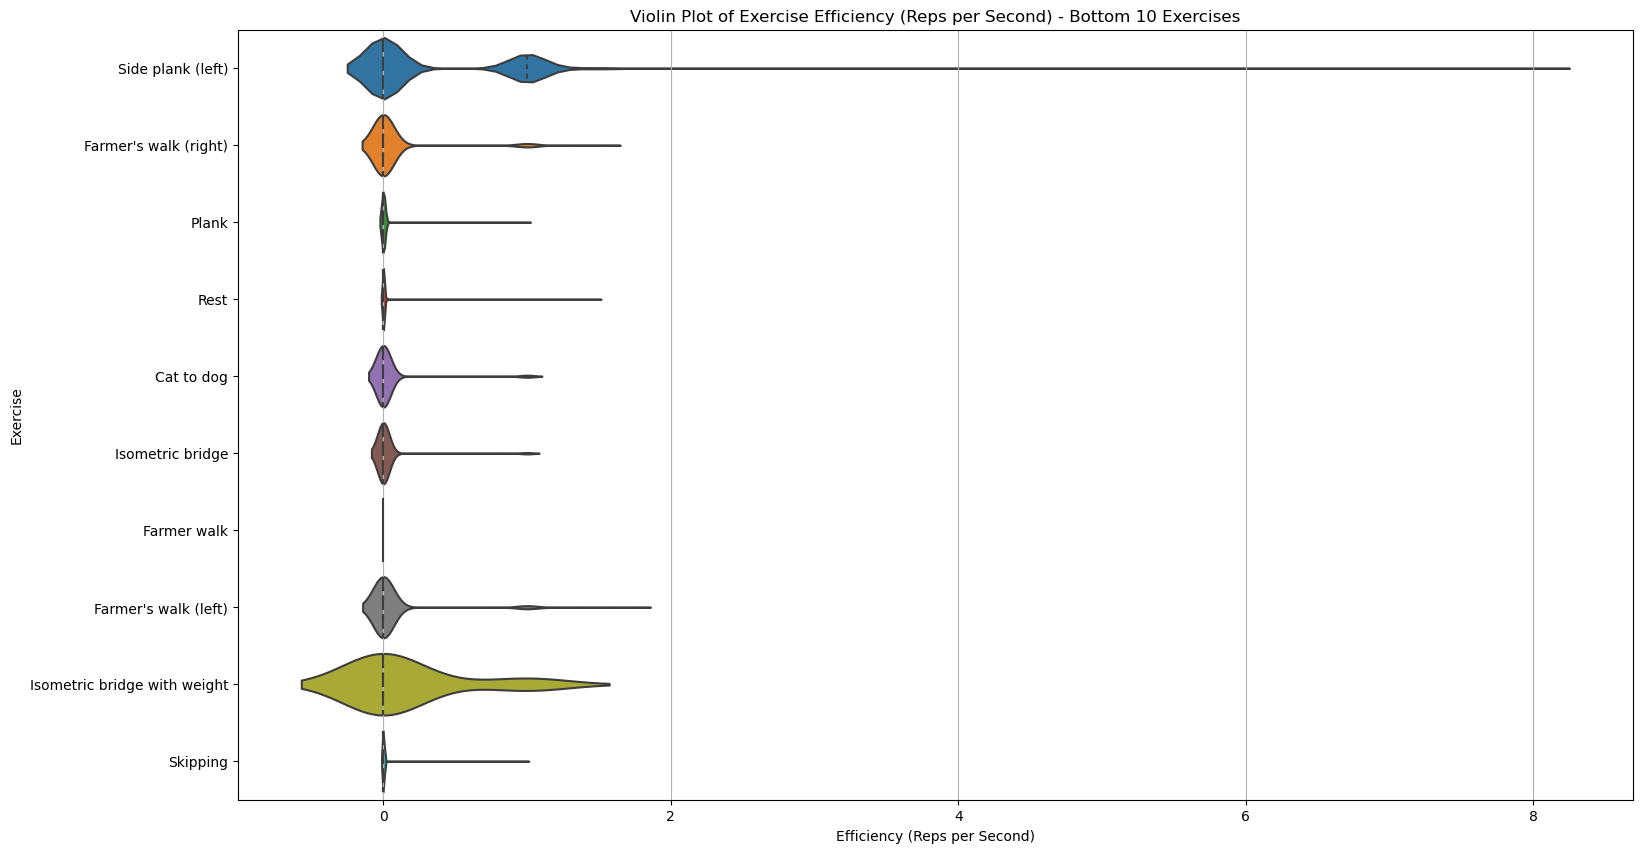

Bottom 10 Exercises by Mean Efficiency
------------------------------------
1. Exercise: Farmer walk, Mean Efficiency: 0.0
2. Exercise: Skipping, Mean Efficiency: 0.0008514261387824606
3. Exercise: Plank, Mean Efficiency: 0.003377110694183865
4. Exercise: Rest, Mean Efficiency: 0.009244996693172853
5. Exercise: Isometric bridge, Mean Efficiency: 0.025157232704402517
6. Exercise: Cat to dog, Mean Efficiency: 0.033073929961089495
7. Exercise: Farmer's walk (left), Mean Efficiency: 0.055761541257724465
8. Exercise: Farmer's walk (right), Mean Efficiency: 0.06018518518518518
9. Exercise: Isometric bridge with weight, Mean Efficiency: 0.16666666666666666
10. Exercise: Side plank (left), Mean Efficiency: 0.3521276595744681

Maximum Efficiency:
Exercise
Cat to dog                      1.000000
Farmer walk                     0.000000
Farmer's walk (left)            1.714286
Farmer's walk (right)           1.500000
Isometric bridge                1.000000
Isometric bridge with weight    1.0000

In [102]:
# Calculate Exercise Efficiency (Reps per Second)
efficiency_data = []

# Loop through each exercise column ending with '_reps' and not 'sum_of_reps'
for col in df_filtered.columns:
    if col.endswith('_reps') and col != 'sum_of_reps':
        exercise_name = col.replace('_reps', '')
        # Identify time column
        time_col = exercise_name + '_time'
        if time_col in df_filtered.columns:
            reps = df_filtered[col]
            time = df_filtered[time_col]
            # Calculate efficiency
            efficiency = reps / time
            efficiency_data.append(pd.DataFrame({'Exercise': [exercise_name] * len(efficiency), 'Efficiency': efficiency}))

# Combine all efficiency data into a single DataFrame
efficiency_df = pd.concat(efficiency_data, ignore_index=True)

# Drop rows with NaN values in Efficiency
efficiency_df = efficiency_df.dropna(subset=['Efficiency'])

# Calculate the mean efficiency for each exercise
mean_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].mean()

# Get the bottom 10 exercises by mean efficiency
bottom_10_exercises = mean_efficiency.nsmallest(10).index

# Filter the efficiency data to include only the bottom 10 exercises
filtered_efficiency_df = efficiency_df[efficiency_df['Exercise'].isin(bottom_10_exercises)]

# Create a violin plot for Exercise Efficiency
plt.figure(figsize=(18, 10))
sns.violinplot(data=filtered_efficiency_df, x='Efficiency', y='Exercise', scale='width', inner='quartile')
plt.xlabel('Efficiency (Reps per Second)')
plt.ylabel('Exercise')
plt.title('Violin Plot of Exercise Efficiency (Reps per Second) - Bottom 10 Exercises')
plt.grid(axis='x')
plt.show()

print('Bottom 10 Exercises by Mean Efficiency')
print('------------------------------------')
for i, exercise in enumerate(bottom_10_exercises, start=1):
    count = mean_efficiency[exercise]
    print(f"{i}. Exercise: {exercise}, Mean Efficiency: {count}")

print('\nMaximum Efficiency:')
print(filtered_efficiency_df.groupby('Exercise')['Efficiency'].max())

print('\nMean Efficiency:')
print(filtered_efficiency_df.groupby('Exercise')['Efficiency'].mean())

print('\nMinimum Efficiency:') 
print(filtered_efficiency_df.groupby('Exercise')['Efficiency'].min())


#### Pie Chart of Exercise Distribution by Series Count

This pie chart visualizes the distribution of the top 10 exercises based on the number of series performed. Each segment of the pie represents a specific exercise, with the size of the segment corresponding to the proportion of series counts for that exercise. The chart provides an overview of which exercises are most frequently performed in terms of series, allowing trainers and athletes to quickly identify the most common exercises in their routines. This information can be useful for balancing workouts, identifying overused exercises, or highlighting those that may need more focus. The addition of a legend and percentage labels enhances the clarity and readability of the chart.

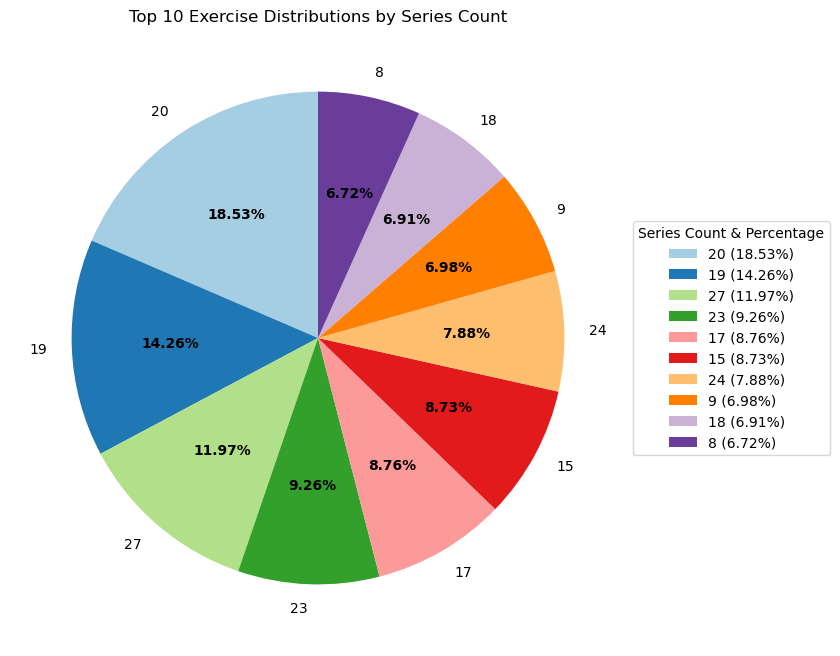

In [103]:
# Calculate value counts for total_count_of_series_reps and get the top 10
exercise_series_counts = df_filtered['total_count_of_series_reps'].value_counts().head(10)

# Calculate the percentages for each series count
percentages = 100 * exercise_series_counts / exercise_series_counts.sum()

# Combine the series count and percentage into a DataFrame for sorting
combined = pd.DataFrame({'count': exercise_series_counts,'percentage': percentages})

# Sort by percentage in descending order
combined = combined.sort_values(by='percentage', ascending=False)

# Create the legend labels with sorted data
legend_labels = [f"{count} ({percentage:.2f}%)" for count, percentage in zip(combined.index, combined['percentage'])]

plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    combined['count'], 
    labels=combined.index, 
    autopct='%1.2f%%', 
    startangle=90,
    colors=plt.cm.Paired(np.arange(len(combined)))
)

plt.title('Top 10 Exercise Distributions by Series Count')
plt.legend(wedges, legend_labels, title="Series Count & Percentage", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
plt.show()


#### Bar Chart of Average Reps per Series for Top Exercises & Bottom Exercises

This graph aims to identify and display the top 10 & bottom 10 exercises with the highest average repetitions per series. By focusing on exercises that have significant repetition counts, it highlights which exercises typically involve more effort in terms of the number of repetitions, and the contrary in the case of the bottom 10 exercises. The graph excludes columns that represent summary data or series counts, ensuring that only individual exercise repetitions are considered. This visualization is useful for trainers and athletes to understand which exercises are performed with higher repetition counts on average, and also the lower repetition ones, helping in planning and adjusting workout routines for optimal training outcomes.

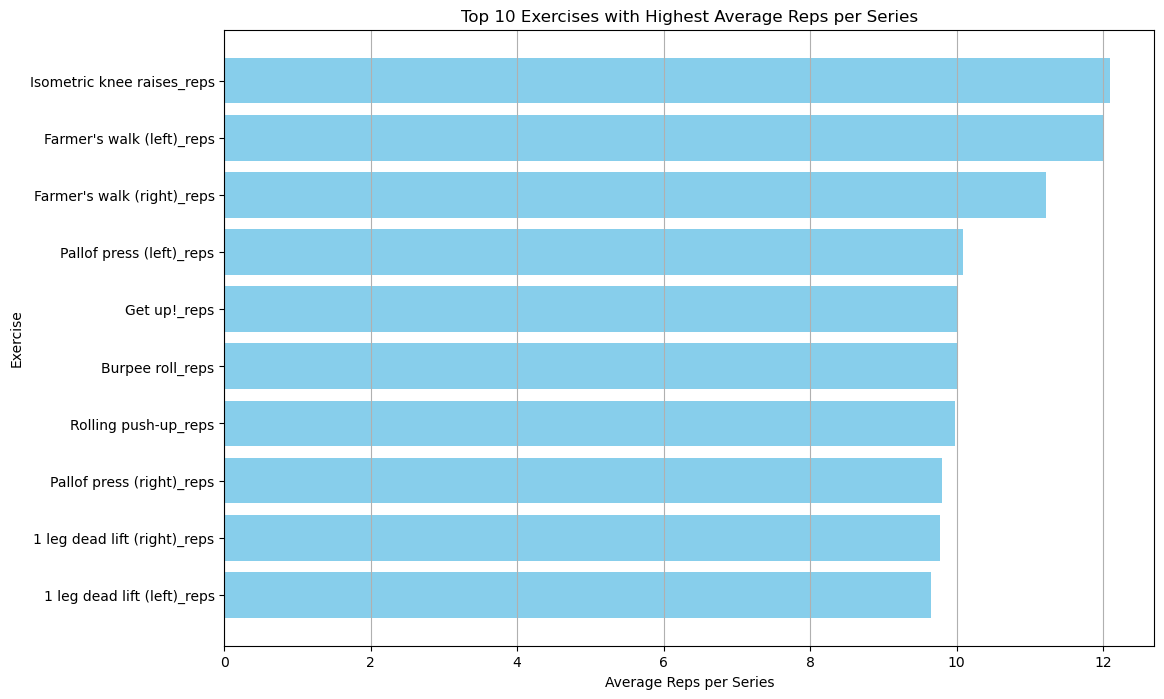

Top 10 Exercises with Highest Average Reps per Series:
                         Exercise  Average Reps per Series
304    Isometric knee raises_reps                12.095238
408     Farmer's walk (left)_reps                12.000000
48     Farmer's walk (right)_reps                11.217391
72       Pallof press (left)_reps                10.086364
205                  Get up!_reps                10.000000
226              Burpee roll_reps                10.000000
210          Rolling push-up_reps                 9.975000
73      Pallof press (right)_reps                 9.807576
127  1 leg dead lift (right)_reps                 9.777563
126   1 leg dead lift (left)_reps                 9.655769


In [104]:
import warnings
warnings.filterwarnings("ignore")

# Filter columns that ends in '_reps' and do not contain 'sum_of_reps' and 'total_count_of_series_reps'
exercise_columns = [col for col in df_filtered.columns if col.endswith('_reps') and 'sum_of_reps' not in col and 'total_count_of_series_reps' not in col]

mean_reps_per_exercise = pd.DataFrame(columns=['Exercise', 'Average Reps per Series'])

# Calculate the mean values of reps per exercise and add to the DataFrame, ignoring columns which all values are 0
for col in exercise_columns:
    non_zero_values = df_filtered[col][df_filtered[col] != 0]
    if not non_zero_values.empty: 
        mean_reps = non_zero_values.mean()
        mean_reps_per_exercise = mean_reps_per_exercise.append({'Exercise': col, 'Average Reps per Series': mean_reps}, ignore_index=True)

mean_reps_per_exercise = mean_reps_per_exercise.sort_values(by='Average Reps per Series', ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(mean_reps_per_exercise['Exercise'], mean_reps_per_exercise['Average Reps per Series'], color='skyblue')
plt.xlabel('Average Reps per Series')
plt.ylabel('Exercise')
plt.title('Top 10 Exercises with Highest Average Reps per Series')
plt.grid(axis='x')
plt.gca().invert_yaxis() 
plt.show()

print('Top 10 Exercises with Highest Average Reps per Series:')
print(mean_reps_per_exercise)

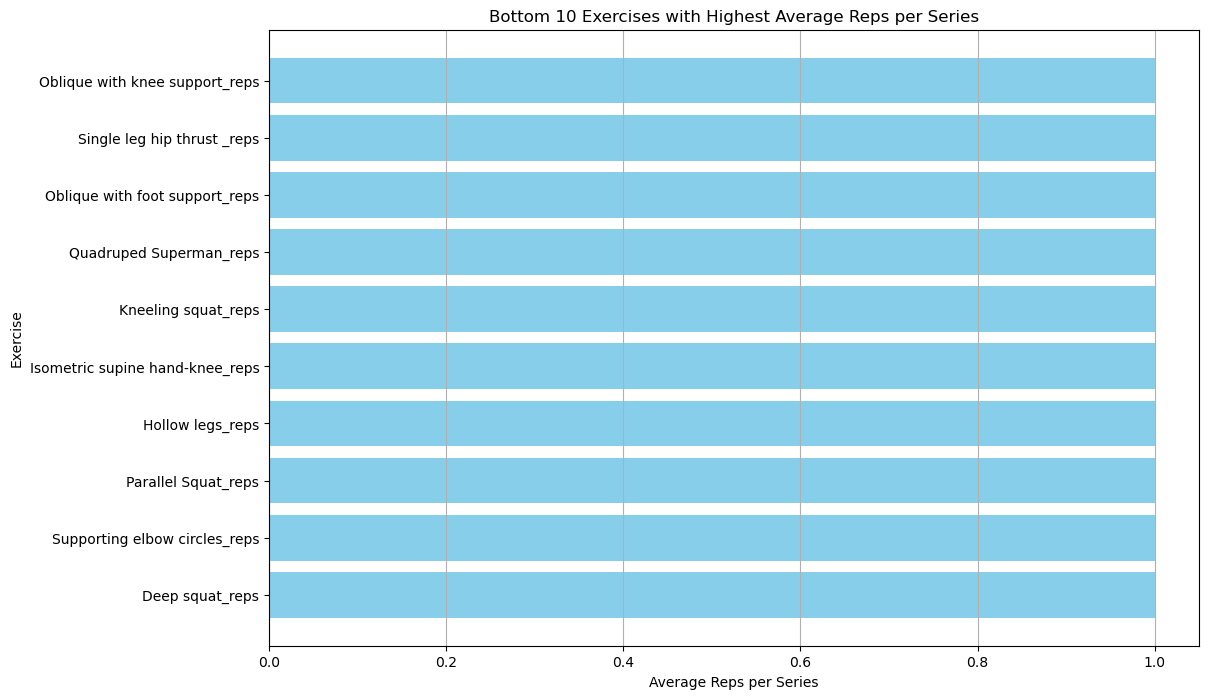

Bottom 10 Exercises with Highest Average Reps per Series:
                            Exercise  Average Reps per Series
318   Oblique with knee support_reps                      1.0
333      Single leg hip thrust _reps                      1.0
332   Oblique with foot support_reps                      1.0
315          Quadruped Superman_reps                      1.0
330              Kneeling squat_reps                      1.0
329  Isometric supine hand-knee_reps                      1.0
284                 Hollow legs_reps                      1.0
286              Parallel Squat_reps                      1.0
108    Supporting elbow circles_reps                      1.0
116                  Deep squat_reps                      1.0


In [105]:
import warnings
warnings.filterwarnings("ignore")

# Filter columns that ends in '_reps' and do not contain 'sum_of_reps' and 'total_count_of_series_reps'
exercise_columns = [col for col in df_filtered.columns if col.endswith('_reps') and 'sum_of_reps' not in col and 'total_count_of_series_reps' not in col]

mean_reps_per_exercise = pd.DataFrame(columns=['Exercise', 'Average Reps per Series'])

# Calculate the mean values of reps per exercise and add to the DataFrame, ignoring columns which all values are 0
for col in exercise_columns:
    non_zero_values = df_filtered[col][df_filtered[col] != 0]
    if not non_zero_values.empty: 
        mean_reps = non_zero_values.mean()
        mean_reps_per_exercise = mean_reps_per_exercise.append({'Exercise': col, 'Average Reps per Series': mean_reps}, ignore_index=True)

mean_reps_per_exercise = mean_reps_per_exercise.sort_values(by='Average Reps per Series', ascending=True).head(10)

plt.figure(figsize=(12, 8))
plt.barh(mean_reps_per_exercise['Exercise'], mean_reps_per_exercise['Average Reps per Series'], color='skyblue')
plt.xlabel('Average Reps per Series')
plt.ylabel('Exercise')
plt.title('Bottom 10 Exercises with Highest Average Reps per Series')
plt.grid(axis='x')
plt.gca().invert_yaxis() 
plt.show()

print('Bottom 10 Exercises with Highest Average Reps per Series:')
print(mean_reps_per_exercise)

#### Training Session with Highest Rest Time

This graph aims to highlight the training sessions with the highest rest times and provide a context for these values by displaying the overall average rest time. By focusing on the top 10 sessions with the longest rest periods, the graph helps in identifying outliers or particularly significant rest intervals in the dataset. The red dashed line indicating the mean rest time serves as a reference point to compare these top values against the typical rest duration observed across all sessions. This visualization can be useful for trainers or athletes to analyze and optimize rest periods during training.

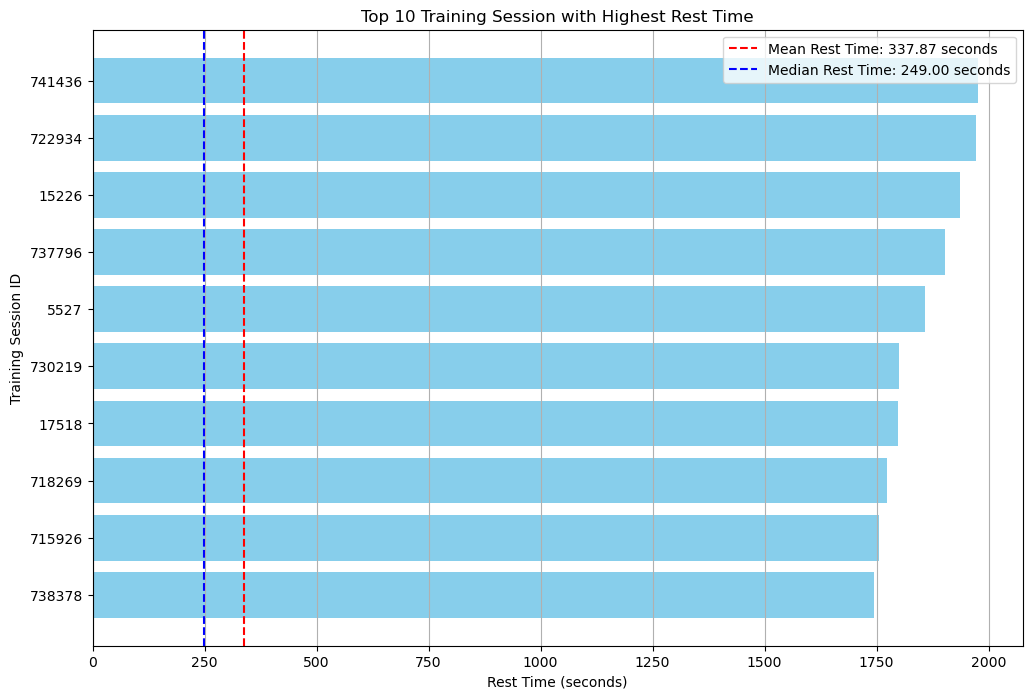

Top 10 Training Session with Highest Rest Time (seconds):
741436    1977.0
722934    1973.0
15226     1937.0
737796    1902.0
5527      1859.0
730219    1800.0
17518     1799.0
718269    1774.0
715926    1756.0
738378    1745.0
Name: Rest_sum_of_time_per_exercise, dtype: float64

Top 10 Training Session with Highest Rest Time (minutes):
741436    32.950000
722934    32.883333
15226     32.283333
737796    31.700000
5527      30.983333
730219    30.000000
17518     29.983333
718269    29.566667
715926    29.266667
738378    29.083333
Name: Rest_sum_of_time_per_exercise, dtype: float64

Mean Rest Time: 337.87 seconds  //  5.631194594124804 minutes

Median Rest Time: 249.00 seconds  //  4.15 minutes


In [109]:
# Filter Maximum Values
top_10_values = df_filtered['Rest_sum_of_time_per_exercise'].nlargest(10)

# Calculate the mean rest time
mean_rest_time = df_filtered['Rest_sum_of_time_per_exercise'].mean()
median_rest_time = df_filtered['Rest_sum_of_time_per_exercise'].median()

plt.figure(figsize=(12, 8))
plt.barh(range(10), top_10_values.values, color='skyblue')
plt.yticks(range(10), top_10_values.index)
plt.axvline(mean_rest_time, color='r', linestyle='--', label=f'Mean Rest Time: {mean_rest_time:.2f} seconds')
plt.axvline(median_rest_time, color='b', linestyle='--', label=f'Median Rest Time: {median_rest_time:.2f} seconds')
plt.xlabel('Rest Time (seconds)')
plt.ylabel('Training Session ID')
plt.title('Top 10 Training Session with Highest Rest Time')
plt.grid(axis='x')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()

print('Top 10 Training Session with Highest Rest Time (seconds):') 
print(top_10_values)
print('\nTop 10 Training Session with Highest Rest Time (minutes):') 
print(top_10_values / 60)

print(f'\nMean Rest Time: {mean_rest_time:.2f} seconds  //  {mean_rest_time / 60} minutes')
print(f'\nMedian Rest Time: {median_rest_time:.2f} seconds  //  {median_rest_time / 60} minutes')